# [Model Exploration]

# 1. Data Organization

In [1]:
from datetime import datetime
start_time = datetime.now()

import pandas as pd
import random
import xgboost as xgb
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
import gc
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [3]:
%%time
vars = pd.read_csv('vars_final (YB).csv')
print(vars.shape)
vars.head()

(97496, 22)
CPU times: user 128 ms, sys: 25.8 ms, total: 154 ms
Wall time: 156 ms


,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60,Card_dow_vdratio_0by14,Merchnum_desc_State_total_3,Card_Merchdesc_total_7,Card_dow_unique_count_for_merch_zip_7,merch_state_total_1,...,Cardnum_unique_count_for_card_zip_3,Merchnum_desc_State_total_1,Cardnum_total_14,Card_dow_count_7,Cardnum_actual/toal_0,Card_dow_total_30,Card_dow_vdratio_0by7,Cardnum_vdratio_1by7,Recnum,Fraud
0,1,3.62,0.033333,3.62,0.000011,0.000049,3.62,3.62,1,3.62,...,1,3.62,3.62,1,1.0,3.62,0.000098,0.000098,1,0
1,1,31.42,0.033333,31.42,0.000011,0.000049,31.42,31.42,1,31.42,...,1,31.42,31.42,1,1.0,31.42,0.000098,0.000098,2,0
2,1,178.49,0.033333,178.49,0.000011,0.000049,178.49,178.49,1,178.49,...,1,178.49,178.49,1,1.0,178.49,0.000098,0.000098,3,0
3,1,3.62,0.033333,3.62,0.000011,0.000049,3.62,3.62,1,7.24,...,1,3.62,3.62,1,1.0,3.62,0.000098,0.000098,4,0
4,1,7.24,0.033333,3.62,0.016667,0.071429,7.24,7.24,1,10.86,...,1,7.24,7.24,2,0.5,7.24,0.142857,0.142857,5,0


# Setting the detection rate 
Setting the detection rate to 0.03 could be a benchmark or target (if  domain knowledge suggests that around 3% of credit card transactions are fraudulent) or FDR metrics (The False Discovery Rate (FDR) or other performance metrics often rely on an expected detection rate. By setting detect_rate = 0.03, I can align the calculation of these metrics with the assumption that I will detect fraud in 3% of cases. This can serve as an initial reference for comparing model performance.)

In [4]:
# set the number of variables desired here, and set the names of the y and record label properly
NVARS = 10

# vars.rename(columns={'record':'Recnum'},inplace=True)
# vars.rename(columns={'fraud_label':'Fraud'},inplace=True)
#
detect_rate = .03
numvars = min(NVARS,len(vars)-2)
final_vars_list = ['Recnum','Fraud']
for i in range(numvars):
    final_vars_list.append(vars.columns[i])
    
final_vars_list

['Recnum',
 'Fraud',
 'Cardnum_unique_count_for_card_state_1',
 'Card_Merchdesc_State_total_7',
 'Cardnum_count_1_by_30',
 'Cardnum_max_14',
 'Card_dow_vdratio_0by60',
 'Card_dow_vdratio_0by14',
 'Merchnum_desc_State_total_3',
 'Card_Merchdesc_total_7',
 'Card_dow_unique_count_for_merch_zip_7',
 'merch_state_total_1']

In [5]:
vars = vars.filter(final_vars_list,axis=1)
vars.head()

,Recnum,Fraud,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60,Card_dow_vdratio_0by14,Merchnum_desc_State_total_3,Card_Merchdesc_total_7,Card_dow_unique_count_for_merch_zip_7,merch_state_total_1
0,1,0,1,3.62,0.033333,3.62,0.000011,0.000049,3.62,3.62,1,3.62
1,2,0,1,31.42,0.033333,31.42,0.000011,0.000049,31.42,31.42,1,31.42
2,3,0,1,178.49,0.033333,178.49,0.000011,0.000049,178.49,178.49,1,178.49
3,4,0,1,3.62,0.033333,3.62,0.000011,0.000049,3.62,3.62,1,7.24
4,5,0,1,7.24,0.033333,3.62,0.016667,0.071429,7.24,7.24,1,10.86


In [6]:
vars.shape

(97496, 12)

In [7]:
vars['Fraud'].sum()

2047

In [8]:
print("fraud rate in data is",vars['Fraud'].sum()/len(vars))

fraud rate in data is 0.020995733158283417


In [9]:
vars.head(10)

,Recnum,Fraud,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60,Card_dow_vdratio_0by14,Merchnum_desc_State_total_3,Card_Merchdesc_total_7,Card_dow_unique_count_for_merch_zip_7,merch_state_total_1
0,1,0,1,3.62,0.033333,3.62,0.000011,0.000049,3.62,3.62,1,3.62
1,2,0,1,31.42,0.033333,31.42,0.000011,0.000049,31.42,31.42,1,31.42
2,3,0,1,178.49,0.033333,178.49,0.000011,0.000049,178.49,178.49,1,178.49
3,4,0,1,3.62,0.033333,3.62,0.000011,0.000049,3.62,3.62,1,7.24
4,5,0,1,7.24,0.033333,3.62,0.016667,0.071429,7.24,7.24,1,10.86
5,6,0,1,3.67,0.033333,3.67,0.000011,0.000049,3.67,3.67,1,14.53
6,7,0,1,3.62,0.033333,3.62,0.000011,0.000049,7.24,3.62,1,18.15
7,8,0,1,230.32,0.033333,230.32,0.000011,0.000049,230.32,230.32,1,230.32
8,9,0,1,62.11,0.033333,62.11,0.000011,0.000049,62.11,62.11,1,62.11
9,10,0,1,10.86,0.033333,3.62,0.016667,0.071429,10.86,10.86,1,21.77


In [10]:
vars.shape

(97496, 12)

In [11]:
vars.describe()

,Recnum,Fraud,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60,Card_dow_vdratio_0by14,Merchnum_desc_State_total_3,Card_Merchdesc_total_7,Card_dow_unique_count_for_merch_zip_7,merch_state_total_1
count,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000
mean,48915.137247,0.020996,1.724266,676.571639,0.008823,1194.385741,0.003231,0.020482,1413.472998,676.717953,1.892016,1122.058892
std,28262.212670,0.143371,1.568565,4074.921736,0.008372,1856.894526,0.004996,0.026914,5123.221915,4074.945381,1.874101,4332.684962
min,1.000000,0.000000,1.000000,0.010000,0.000078,0.140000,0.000007,0.000039,0.010000,0.010000,1.000000,0.010000
25%,24428.750000,0.000000,1.000000,52.500000,0.003226,307.000000,0.000152,0.001587,99.900000,52.500000,1.000000,117.350000
50%,48916.000000,0.000000,1.000000,189.000000,0.005556,801.660000,0.000370,0.002976,356.450000,189.000000,1.000000,397.100000
75%,73402.250000,0.000000,2.000000,590.000000,0.011111,1743.000000,0.004762,0.042857,1325.600000,590.000000,2.000000,1152.417500
max,97852.000000,1.000000,21.000000,306633.410000,0.033333,47900.000000,0.016667,0.071429,307302.580000,306633.410000,38.000000,306633.410000


In [12]:
# find the row i vars that corresponds to 11/1 for the OOT
test = vars[vars['Recnum'] > 85264]
test.head(10)

,Recnum,Fraud,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60,Card_dow_vdratio_0by14,Merchnum_desc_State_total_3,Card_Merchdesc_total_7,Card_dow_unique_count_for_merch_zip_7,merch_state_total_1
84935,85265,0,1,174.61,0.016667,225.00,0.000074,0.000317,174.61,174.61,1,174.61
84936,85266,0,1,53.00,0.002778,395.00,0.000278,0.001190,53.00,53.00,1,53.00
84937,85267,0,1,25.00,0.004762,531.25,0.000417,0.002976,25.00,25.00,2,25.00
84938,85268,0,1,97.17,0.004762,395.04,0.000194,0.001661,97.17,97.17,1,97.17
84939,85269,0,1,6.51,0.016667,6.51,0.000167,0.001429,6.51,6.51,1,6.51
84940,85270,0,1,170.00,0.016667,170.00,0.000260,0.001116,170.00,170.00,1,170.00
84941,85271,0,1,250.00,0.002564,250.00,0.000149,0.001786,250.00,250.00,2,250.00
84942,85272,0,1,15.00,0.016667,103.60,0.000167,0.001429,15.00,15.00,1,15.00
84943,85273,0,1,300.00,0.006667,2105.00,0.000024,0.001984,300.00,300.00,1,300.00
84944,85274,0,1,133.20,0.002564,268.20,0.001042,0.004464,133.20,133.20,2,97.02


In [13]:
record_save = vars['Recnum']
Y_save = pd.DataFrame(vars.loc[:,'Fraud'])
Y_save.head()

,Fraud
0,0
1,0
2,0
3,0
4,0


# 2. Z-Scaling (Standardization) and Outlier treatment

- Z-Scaling (Standardization): This transforms the features to have a mean of 0 and a standard deviation of 1. It ensures that the model doesn't give more importance to features that are on a larger scale compared to others.

- Outlier Treatment: Clipping outliers helps reduce the impact of extreme values in the dataset. In fraud detection, transactions with abnormally high values might be considered outliers, but this step ensures that these extreme values are not disproportionately affecting the model.

- OOT (Out-of-Time): This dataset is held out from training and testing and is used to evaluate how the model performs on future data. It's often used to check the robustness of the model over time.

### 1) Exclude columns that are not the target for z-scaling

In [14]:
X_no_scaling = vars.drop(columns = ['Recnum','Fraud'])
X_no_scaling.describe()

,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60,Card_dow_vdratio_0by14,Merchnum_desc_State_total_3,Card_Merchdesc_total_7,Card_dow_unique_count_for_merch_zip_7,merch_state_total_1
count,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000
mean,1.724266,676.571639,0.008823,1194.385741,0.003231,0.020482,1413.472998,676.717953,1.892016,1122.058892
std,1.568565,4074.921736,0.008372,1856.894526,0.004996,0.026914,5123.221915,4074.945381,1.874101,4332.684962
min,1.000000,0.010000,0.000078,0.140000,0.000007,0.000039,0.010000,0.010000,1.000000,0.010000
25%,1.000000,52.500000,0.003226,307.000000,0.000152,0.001587,99.900000,52.500000,1.000000,117.350000
50%,1.000000,189.000000,0.005556,801.660000,0.000370,0.002976,356.450000,189.000000,1.000000,397.100000
75%,2.000000,590.000000,0.011111,1743.000000,0.004762,0.042857,1325.600000,590.000000,2.000000,1152.417500
max,21.000000,306633.410000,0.033333,47900.000000,0.016667,0.071429,307302.580000,306633.410000,38.000000,306633.410000


### 2) Z-scaling: Mean=0, STD=1, performed by subtracting the mean of each collumn from the collumn values and dividing by the std of each column


In [15]:
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()

### 3) Outlier treatment: Any value above 10 is set to 10, and any value below -10 is set to -10

In [16]:
# Outlier treatment: use this to limit variables. For some problems it helps
Clip = 10
X.clip(-1*Clip,Clip,inplace=True)

### 4) Re-scaling after outlier treatment

In [17]:
# push in any outlier values, then rescale
X = (X - X.mean()) / X.std()
X.describe()

,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60,Card_dow_vdratio_0by14,Merchnum_desc_State_total_3,Card_Merchdesc_total_7,Card_dow_unique_count_for_merch_zip_7,merch_state_total_1
count,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,97496.000000,9.749600e+04,9.749600e+04,9.749600e+04
mean,-3.469048e-17,1.457583e-18,3.148380e-17,1.836555e-17,-1.588766e-17,3.410745e-17,0.000000,-5.538817e-18,1.107763e-17,-1.982313e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.651796e-01,-3.346282e-01,-1.044444e+00,-7.194261e-01,-6.452996e-01,-7.595529e-01,-0.431853,-3.346955e-01,-5.031954e-01,-4.449551e-01
25%,-4.651796e-01,-3.065413e-01,-6.685133e-01,-5.318162e-01,-6.163864e-01,-7.020303e-01,-0.399940,-3.066096e-01,-5.031954e-01,-3.962655e-01
50%,-4.651796e-01,-2.335016e-01,-3.902418e-01,-2.293881e-01,-5.725765e-01,-6.504263e-01,-0.317979,-2.335723e-01,-5.031954e-01,-2.801850e-01
75%,1.782986e-01,-1.893059e-02,2.733285e-01,3.461339e-01,3.065090e-01,8.313456e-01,-0.008358,-1.900840e-02,6.696772e-02,3.322953e-02
max,1.009425e+01,2.183188e+01,2.927610e+00,1.136351e+01,2.689572e+00,1.892914e+00,16.387194,2.183128e+01,1.069083e+01,1.799885e+01


### 5) Splitting the data into train-test and OOT

- Train-Test Data (X_trntst, Y_trntst): All rows up to the oot_recnum, which is set to 85264, are assigned to the train-test data.
- Out-of-Time Data (X_oot, Y_oot): All rows after oot_recnum are assigned to the Out-of-Time (OOT) data. This data represents transactions that come from a different time period than the training and testing data. It's used to simulate how the model would perform on new, unseen data that might come from a future time frame.
- Y_oot.sum(): This line sums the Y_oot values to check how many positive (fraudulent) cases are in the OOT dataset.


In [18]:
# separate data into modeling (traintest) and out of time
# need to change this OOT record number to whatever is appropriate for the data
oot_recnum = 85264
X_trntst = X[0:oot_recnum]
Y_trntst = Y_save[0:oot_recnum]
X_oot = X[oot_recnum:]
Y_oot = Y_save[oot_recnum:]
Y_oot.sum()

Fraud    297
dtype: int64

In [19]:
X_oot.head()

,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60,Card_dow_vdratio_0by14,Merchnum_desc_State_total_3,Card_Merchdesc_total_7,Card_dow_unique_count_for_merch_zip_7,merch_state_total_1
85264,0.178299,-0.260331,-0.668513,-0.090457,0.094681,-0.097526,-0.387494,-0.260401,1.777457,-0.387340
85265,-0.465180,-0.311475,2.927610,-0.621445,1.021428,1.892914,-0.405579,-0.311543,0.066968,-0.410830
85266,-0.465180,0.755184,0.273329,0.525698,-0.594587,-0.719539,0.950422,0.755080,-0.503195,1.350379
85267,0.178299,-0.227616,-0.485038,0.573221,-0.630281,-0.669492,-0.367961,-0.227686,-0.503195,-0.361970
85268,-0.465180,-0.010685,-0.556134,-0.349373,-0.608368,-0.669492,-0.082397,-0.010763,-0.503195,0.008927


In [20]:
Y_oot.head()

,Fraud
85264,0
85265,0
85266,0
85267,0
85268,0


# 3. PCA

- Principal Component Analysis (PCA): a dimensionality reduction technique that is widely used in machine learning and data analysis to reduce the number of features (or variables) while preserving as much variance (information) as possible.
- Dimensionality reduction: In many datasets, especially those with a large number of features, certain features may be highly correlated or contribute minimally to the variance in the data. PCA is used to reduce the number of features by identifying the principal components—linear combinations of the original features that capture the maximum variance in the data.
- The reason why Z-scaling comes before PCA: PCA relies on variance to identify the principal components. If the features are on different scales (e.g., one feature in thousands, another in decimals), the features with larger scales will dominate the variance and skew the PCA results. Therefore, Z-scaling ensures that each feature contributes equally to the PCA process.

- Let’s assume you have 10 original variables, and after applying PCA, you keep only the first 4 principal components (PCA 1-4). These 4 components might explain, say, 85% of the total variance in the data. That means 15% of the variance is not captured by PCA 1-4, but PCA 1-4 still represent the majority of the information from the original 10 variables. By keeping just 4 components, you are reducing the complexity of the dataset while retaining the most significant variation in the data.


In [21]:
len(X_trntst.columns)

10

In [22]:
X_trntst_save = X_trntst.copy()

### 1) Performing PCA with 99.9% variance preservation 

In [23]:
pca = PCA(n_components = .999, svd_solver = 'full')

### 2) Fitting PCA to the Train-Test Data
- This step computes the principal components for the dataset and calculates how much variance is explained by each component.

In [24]:
pca.fit(X_trntst)

PCA(n_components=0.999, svd_solver='full')

### 3) Plotting the explained variance ratio

- line plot to show how much variance each principal component explains. PC1 (the first principal component) captures the largest possible variance in the data, while PC2 captures the second largest variance, and so on. PCA components are orthogonal (uncorrelated) to each other, meaning each new component explains a unique part of the variance in the data. For example: PC1 (Principal Component 1) might explain 40% of the variance, PC2 might explain 20%, and so on.

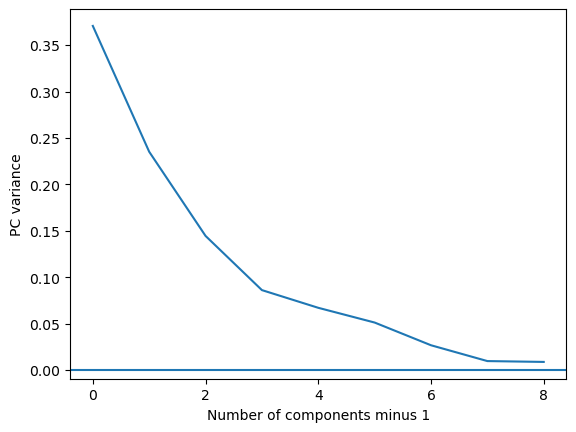

In [25]:
plt.plot(pca.explained_variance_ratio_)

plt.xlabel('Number of components minus 1')
plt.ylabel('PC variance')
plt.xticks(np.arange(0, len(X_trntst.columns), step=2))
plt.axhline(y=0,xmin=0,xmax=len(X_trntst.columns))
X_trntst = X_trntst_save.copy()

- The first principal component (PC1) explains the largest portion of the variance, as indicated by the steep drop at the beginning. In this case, it explains slightly over 0.35 (or 35%) of the variance. This is expected since the first principal component always captures the most variance in the dataset.

- The second principal component explains around 0.20 (or 20%) of the variance, significantly less than PC1 but still a substantial portion of the overall variance.


- The first 3 or 4 components seem to explain most of the variance in the data, with each subsequent component explaining much less variance. Based on this scree plot, I might choose to keep the first 3 or 4 principal components, as they capture most of the relevant information. After that, the remaining components add very little to the overall explanation of variance. This choice would allow me to reduce the dimensionality of my data while retaining most of the important information.

### 4) Selecting the number of PCs and fitting PCA to the Train-Test data
- fit_transform(X_trntst): This applies PCA to the train-test dataset (X_trntst) and transforms it into the new space defined by the first 4 principal components.
- The result is a new dataset (X_trntst_pca) containing 4 columns, corresponding to PC1, PC2, PC3, PC4 (the top 4 principal components).
- A new DataFrame (X_trntst_pca) is created with PC1 through PC4 as column names. This dataset now represents my original data but in a reduced dimensional space.

In [26]:
# I look at the above picture, select how many PCs I want to keep, and then redo the PCA with just this many PCs
pca = PCA(n_components = 4, svd_solver = 'full')
princ_comps = pca.fit_transform(X_trntst)
X_trntst_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
X_trntst_pca.head()

,PC1,PC2,PC3,PC4
0,-1.030410,-0.418586,-1.438941,2.520959
1,-1.002324,-0.423580,-1.434036,2.517403
2,-0.853736,-0.450005,-1.408091,2.498590
3,-1.029703,-0.418745,-1.439031,2.521088
4,-0.308834,2.626571,-3.518368,0.604063


### 5) Transforming the Out-of-Time (OOT) Data Using the Same PCA
- After fitting PCA to the train-test data, the same transformation is applied to the Out-of-Time (OOT) data.
- pca.transform(X_oot) projects the OOT data onto the same principal components that were learned from the train-test data.
- This creates a new DataFrame X_oot_orig_pca with the same 4 principal components (PC1, PC2, PC3, PC4), now applied to the OOT data.

In [27]:
princ_comps = pca.transform(X_oot)
X_oot_orig_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)],index=X_oot.index)
X_oot_orig_pca.head()

,PC1,PC2,PC3,PC4
85264,-0.530050,0.859637,1.243127,-0.155989
85265,-0.399901,2.022557,-2.572898,1.144138
85266,1.691886,-1.449249,-0.069773,0.460925
85267,-0.627824,-0.747159,0.736028,-0.198413
85268,-0.398630,-1.187807,0.085223,-0.117018


In [28]:
X_trntst.describe()

,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60,Card_dow_vdratio_0by14,Merchnum_desc_State_total_3,Card_Merchdesc_total_7,Card_dow_unique_count_for_merch_zip_7,merch_state_total_1
count,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000
mean,0.004006,0.002794,-0.013411,0.003866,0.000122,0.003494,0.011369,0.002805,0.004227,0.009640
std,1.007299,1.029148,0.996083,0.988241,0.999618,1.000623,1.038863,1.029151,1.014974,1.024284
min,-0.465180,-0.334628,-1.044444,-0.719426,-0.645300,-0.759504,-0.431853,-0.334696,-0.503195,-0.444955
25%,-0.465180,-0.307403,-0.680554,-0.528478,-0.616386,-0.699287,-0.400153,-0.307467,-0.503195,-0.395166
50%,-0.465180,-0.234920,-0.390242,-0.220376,-0.572577,-0.640374,-0.318782,-0.234966,-0.503195,-0.276533
75%,0.178299,-0.019391,0.273329,0.354082,0.306509,0.831346,-0.004259,-0.019273,0.066968,0.042854
max,10.094246,21.831881,2.927610,11.363510,2.689572,1.892914,16.387194,21.831284,10.690830,17.998850


In [29]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4
count,12232.000000,12232.000000,12232.000000,12232.000000
mean,-0.110126,0.000168,-0.069501,0.065105
std,1.497495,1.486984,1.178587,0.941301
min,-1.192704,-8.003357,-4.255619,-5.499669
25%,-0.851507,-1.023223,-0.586317,-0.412510
50%,-0.443378,-0.672670,0.040021,-0.068759
75%,0.125227,0.947480,0.461670,0.417564
max,39.452018,11.307276,8.213417,4.873170


### 6) Z-scaling the principal components
- After generating the principal components, I want to Z-scale them to standardize their distribution, ensuring they have a mean of 0 and standard deviation of 1.

In [30]:
# zscale the PCs
mean = X_trntst_pca.mean()
stdev = X_trntst_pca.std()
X_trntst_pca = (X_trntst_pca - mean)/stdev
X_oot_orig_pca = (X_oot_orig_pca - mean)/stdev

In [31]:
X_trntst_pca.describe()

,PC1,PC2,PC3,PC4
count,8.526400e+04,8.526400e+04,8.526400e+04,8.526400e+04
mean,-1.066681e-17,-6.000079e-18,3.333377e-19,-1.766690e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-6.187984e-01,-5.836383e+00,-4.186300e+00,-5.743192e+00
25%,-4.194945e-01,-6.668872e-01,-4.347675e-01,-5.272617e-01
50%,-2.100818e-01,-4.061636e-01,7.600688e-02,-1.409813e-01
75%,9.606698e-02,5.699159e-01,4.344830e-01,3.519644e-01
max,2.077754e+01,7.737805e+00,1.054470e+01,6.581682e+00


In [32]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4
count,12232.000000,12232.000000,12232.000000,12232.000000
mean,-0.056470,0.000108,-0.057078,0.069251
std,0.767874,0.957261,0.967914,1.001247
min,-0.611586,-5.152243,-3.494925,-5.849910
25%,-0.436630,-0.658710,-0.481512,-0.438780
50%,-0.227352,-0.433038,0.032867,-0.073137
75%,0.064213,0.609950,0.379146,0.444156
max,20.229916,7.279174,6.745265,5.183513


In [33]:
X_trntst_pca.shape

(85264, 4)

In [34]:
X_oot_orig_pca.shape

(12232, 4)

# 4. Subsample the larger class if desired

- This code is performing subsampling to balance the dataset by reducing the number of non-fraud (goods) cases to match the number of fraud (bads) cases, creating a balanced dataset with a desired ratio of goods to bads for model training. This process is crucial in imbalanced datasets, like fraud detection, to prevent the model from being biased toward the majority class and to improve its ability to detect the minority class (fraud).

In [35]:
# set the ratio of goods to bads that I would like. This next line is the ratio of goods to bads that I want for modeling
sample_ratio_desired = 1

temp = X_trntst.copy()
temp['Fraud'] = Y_trntst['Fraud']
temp.head()
goods = temp[temp['Fraud']==0]
bads = temp[temp['Fraud']==1]
actual_bad_fraction = len(bads)/len(temp)
actual_good_fraction = 1 - actual_bad_fraction
print(actual_bad_fraction)
fraction = sample_ratio_desired * actual_bad_fraction
goods_sampled = goods.sample(frac = fraction)
all_sampled = pd.concat([goods_sampled,bads])
all_sampled.sort_index(inplace=True)
Y_trntst_sampled = pd.DataFrame(all_sampled['Fraud'])
X_trntst_sampled = all_sampled.drop(columns=['Fraud'])
del [temp,goods,bads,all_sampled]
gc.collect()
print(X_trntst_sampled.shape,len(Y_trntst_sampled))

0.020524488647025708
(3464, 10) 3464


### 1) Cross Validation Parameters
- The code block provided is setting up parameters and variables for performing manual cross-validation with multiple iterations and different hyperparameters. 
- niter = 0: This initializes the iteration counter to 0. It will likely be incremented in a loop to keep track of the number of iterations during cross-validation.
- nitermax = 10: This sets the maximum number of iterations for the cross-validation to 10. The model will be trained and tested 10 times with different hyperparameter combinations.
- jittersize = .1: This parameter is likely used for jittering, which adds small random noise to the data (or hyperparameters) to prevent overfitting and improve model generalization. The jitter size is set to 0.1, meaning small random perturbations of this magnitude will be added to the data or hyperparameters during each iteration.

In [1]:
# do a manual cross validation by running each model nitermax times for each choice of hyperparameters. The good
# statistical measurement of the model performance is the average across all these nitermax runs.
niter = 0
nitermax = 10
jittersize = .1
X_oot_orig = X_oot.copy()
pd.options.mode.chained_assignment = None  # default='warn'

NameError: name 'X_oot' is not defined

# 5. Model Experimentation

I can comment in/out any of these model cells and/or just explore one model type. I can also just rerun any single cell multiple times (hit shift-enter on that cell) as I "manually" explore different model hyperparameters.

To evaluate a model with particular hyperparameters, train & evaluate it 10 times.
The differences between runs are due to the random nature inside the model algorithm.
I need to average over multiple runs to get a more accurate result for any particular choice of model hyperparameters.

### 1) Modeling setup

- Modeling_output: A DataFrame that will store the performance results for each model run. It has columns for the model name (Model), training (Trn), test (Tst), and out-of-time (OOT) dataset results.
- counter: Keeps track of the number of model runs and is used to incrementally fill the Modeling_output DataFrame.
- model_counter: Tracks the number of models evaluated.

In [37]:
Modeling_output = pd.DataFrame(columns=['Model','Trn','Tst','OOT'],index=range(1000))
counter = 0
model_counter = 0

# 5.1. Logistic Regression

### 1. Logistic Regression Model Setup
- FDR: A dataframe to store the FDR for each iteration with three columns (trn, tst, oot)
- nitermax: The number of times the model will be trained and evaluated with different splits of data

### 2. Train-Test Split
- X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3): split into 70% training and 30% testing sets

### 3. Model Initialization & *Hyperparameters*
- model=LogisticRegression(): initializes a logistic regression model, save the copy to store the original data
- Penalty: L1 (Lasso regularization: shrink less important feature coefficients to zero, essentially performing feature selection), L2 (Ridge regularization: shrinks coefficients but doesn't set any of them to zero, helps reduce overfitting while keeping all features), ElasticNet (combines both L1 and L2)
- C: Regularization strength. Smaller values mean stronger regularization
- solver: Find the optimal coefficients for minimizing the loss function. lbfgs (handles L2 regularization, large datasets), liblinear (L1, small datasets), sag (L2, large datasets), saga (ElasticNet)
- l1_ratio: Mixed ratio btw L1 and L2 for ElasticNet. l1_ratio=0 (purely L2 Ridge), l1_ratio=1 (purely L1 Lasso)

### 4. Model Fitting and Predictions
- model.fit(X_trn, Y_trn.values.ravel()): trained on the training data, ensures Y_trn is passed in as a 1D array

### 5. FDR Calculation for the Training Data
- model.predict_proba(X_trn_save)[:, 1]: Predicts the probability of fraud for the training data. The second column ([:, 1]) contains the probabilities of the positive class (fraud).
- X_trn['predicted']: Stores the predicted probabilities in the training dataset.
- Sorting and selecting top rows: The training data is sorted based on the predicted fraud probability ('predicted'), and the top 3% of the rows (based on detect_rate) are selected.
- FDR calculation: The FDR (False Discovery Rate) is calculated by dividing the number of actual fraud cases (needed) in the top 3% by the total number of fraud cases in the dataset.

### 6. FDR Calculation for the Testing Data
- The same process is repeated for the test dataset: predictions are made, the top 3% of records with the highest predicted fraud probability are selected, and the FDR is calculated for the test dataset.

### 7. FDR Calculation for the OOT Data
- The process is repeated for the out-of-time (OOT) dataset. Predictions are made for the OOT data, and the FDR is calculated in the same way as for the training and testing datasets.

### 8. Storing Results
- After each iteration, the FDR values for the training, testing, and OOT datasets are printed and stored in the Modeling_output DataFrame. The counter variable is incremented after each iteration to store the results in the correct row.

### 9. Output the Mean FDR
- After all iterations are completed, the mean FDR values for the training, testing, and OOT datasets across all iterations are printed, giving an overall estimate of model performance.
- model_counter is incremented, indicating that this model (logistic regression) has been evaluated.

In [51]:
%%time
# Logistic regression

#1. Logistic Regression Model Setup
FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    #2. Train-Test Split
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    #3. Model Initialization & Hyperparameters
    model = LogisticRegression(
    penalty='elasticnet',       
    C=0.05,              
    solver='saga',
    l1_ratio=0.1,          
)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    #4. Model Fitting and Predictions
    model.fit(X_trn, Y_trn.values.ravel())   
    
    #5. FDR Calculation for the Training Data
    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    #6. FDR Calculation for the Testing Data
    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    #7. FDR Calculation for the OOT Data
    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    
    #8. Storing Results
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['log reg',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1

#9. Output the Mean FDR
print(FDR.mean())
model_counter = model_counter + 1

0 0.6936135812449474 0.6686159844054581 0.4882154882154882
1 0.6853035143769968 0.6907630522088354 0.49158249158249157
2 0.6850828729281768 0.6832298136645962 0.48148148148148145
3 0.6786858974358975 0.701195219123506 0.49158249158249157
4 0.6891233766233766 0.6776061776061776 0.48484848484848486
5 0.6656176239181747 0.7411273486430062 0.4882154882154882
6 0.6785418392709196 0.6961325966850829 0.4882154882154882
7 0.6976929196499603 0.6612576064908722 0.4882154882154882
8 0.6805671392827356 0.6932849364791288 0.49158249158249157
9 0.6623481781376518 0.7456310679611651 0.4882154882154882
trn    0.681658
tst    0.695884
oot    0.488215
dtype: float64
CPU times: user 11.2 s, sys: 13.8 s, total: 25 s
Wall time: 3.56 s


# 5.2. Decision Tree (Single)

### 1. Criterion: Defines how to evaluate the quality of a split (Gini or Entropy).
- gini: faster to compute and is the default criterion.
- entropy: more computationally expensive but can sometimes result in a more accurate tree.

### 2. Max depth: Limits how deep the tree can grow. Deeper trees capture more complexity but may overfit.
- Smaller depth (e.g., 3-5) will result in a simpler model with fewer decision rules, which can generalize better but may underfit the data.
- Larger depth (e.g., 10-20) allows the tree to capture more complexity, but it may overfit by learning noise in the training data.

### 3. Min samples leaf: Defines the minimum number of samples required at a leaf. Higher values generalize better but may underfit.
- Higher values (e.g., 5, 20) will result in more generalized trees, as the leaf nodes will need more samples, which reduces the chance of overfitting.
- Lower values (e.g., 1) will allow the model to split until there’s only one sample per leaf, which can lead to overfitting.

### 4. Splitter: Determines how the algorithm chooses the feature to split. "Best" is optimal; "Random" is faster but less precise.
- best: generally gives better performance, as it optimally splits based on the selected criterion (Gini or Entropy).
- random: might make the model faster but could lead to less accurate results since the splits aren't chosen optimally.

In [65]:
%%time
# Single DT

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = DecisionTreeClassifier(
        criterion='gini',         
        max_depth=10,            
        min_samples_leaf=80,       
        splitter='best'           
)
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['DT',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1

print(FDR.mean())
model_counter = model_counter + 1

0 0.7458745874587459 0.7304832713754646 0.5016835016835017
1 0.742472266244057 0.7233606557377049 0.6161616161616161
2 0.7464454976303317 0.7417355371900827 0.5488215488215489
3 0.7471169686985173 0.6921641791044776 0.5757575757575758
4 0.7574536663980661 0.7367387033398821 0.5858585858585859
5 0.7506132461161079 0.7229601518026565 0.4983164983164983
6 0.7491909385113269 0.7159533073929961 0.569023569023569
7 0.7567340067340067 0.7117437722419929 0.4882154882154882
8 0.7364217252396166 0.7570281124497992 0.5050505050505051
9 0.746268656716418 0.7389705882352942 0.5084175084175084
trn    0.747859
tst    0.727114
oot    0.539731
dtype: float64
CPU times: user 4.45 s, sys: 125 ms, total: 4.58 s
Wall time: 4.58 s


# 5.3. Random Forest

### 1. Criterion: Defines how to evaluate the quality of a split (Gini or Entropy).
- gini: faster to compute and is the default criterion.
- entropy: more computationally expensive but can sometimes result in a more accurate tree.

### 2. Max depth: Limits how deep the tree can grow. Deeper trees capture more complexity but may overfit.
- Smaller depth (e.g., 3-5) will result in a simpler model with fewer decision rules, which can generalize better but may underfit the data.
- Larger depth (e.g., 10-20) allows the tree to capture more complexity, but it may overfit by learning noise in the training data.

### 3. Min samples leaf: Defines the minimum number of samples required at a leaf. Higher values generalize better but may underfit.
- Higher values (e.g., 5, 20) will result in more generalized trees, as the leaf nodes will need more samples, which reduces the chance of overfitting.
- Lower values (e.g., 1) will allow the model to split until there’s only one sample per leaf, which can lead to overfitting.

### 4. n_estimators: This parameter defines the number of decision trees that are built in the Random Forest.
- n_estimators=100 is a good default value. It provides a good trade-off between accuracy and computation time.
- For larger datasets or when more accuracy is needed, can go up to n_estimators=200 or n_estimators=500.
- Very large values like n_estimators=1000 can further improve accuracy but take significantly longer to run. It is useful only when computation time is not a concern.

### 5. bootstrap:  This parameter defines whether or not bootstrap samples are used when building trees. Bootstrapping is a method that resamples the training data with replacement, so each tree sees a different version of the dataset.
- bootstrap=True: Each tree is trained on a bootstrapped subset of the data (a random sample with replacement). This introduces additional randomness, helping to reduce overfitting and increasing model generalization. Standard setting: This is the default setting in Random Forests and is generally the recommended option.
- bootstrap=False: Each tree is trained on the entire training dataset without any bootstrapping. Use only if want all trees to see the entire dataset (which is rare in practice).

In [75]:
%%time
# RF

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    mmodel = RandomForestClassifier(
        criterion='gini',          
        max_depth=10,              
        min_samples_leaf=60,        
        n_estimators=200,          
        bootstrap=True             
)
    
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['RF',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

0 0.752373417721519 0.7057613168724279 0.5218855218855218
1 0.7388429752066116 0.7444444444444445 0.5016835016835017
2 0.7540064102564102 0.7191235059760956 0.5151515151515151
3 0.7384737678855325 0.7195121951219512 0.5016835016835017
4 0.7326968973747017 0.7281947261663286 0.5016835016835017
5 0.7514356029532404 0.7080979284369114 0.494949494949495
6 0.7481662591687042 0.7246653919694073 0.48148148148148145
7 0.754328112118714 0.7057728119180633 0.4983164983164983
8 0.7542717656631408 0.7140115163147792 0.5387205387205387
9 0.754071661237785 0.7145593869731801 0.48484848484848486
trn    0.747867
tst    0.718414
oot    0.504040
dtype: float64
CPU times: user 4.47 s, sys: 138 ms, total: 4.61 s
Wall time: 4.61 s


# 5.4. LightLGBM

### 1. Subsample: The process of using a fraction of the data to train each tree in the boosting process. Reduces overfitting by training trees on a subset of data.
- Typical Values: Values range between 0.5 to 1.0. For example, 0.8 means that 80% of the data will be used for training each tree.
- Effect: A lower value may reduce overfitting but could also lead to underfitting if it's too small. A value of 1.0 disables subsampling.
- Common: 0.7 - 0.9 is often used to reduce overfitting.

### 2. Max depth: Limits how deep the tree can grow. Deeper trees capture more complexity but may overfit.
- Smaller depth (e.g., 3-5) will result in a simpler model with fewer decision rules, which can generalize better but may underfit the data.
- Larger depth (e.g., 10-20) allows the tree to capture more complexity, but it may overfit by learning noise in the training data.

### 3. Learning_rate: Controls the contribution of each tree in the boosted ensemble. Balances the model's speed of learning vs. generalization. 
- It multiplies the predictions of each individual tree before they are added to the final model's prediction.
- Effect: A smaller learning rate slows down the learning process but allows more trees to be built, typically resulting in better generalization. A larger learning rate can make the model fit faster but can cause overfitting or make the model unstable.
- Common: Default is 0.1. For better generalization, can reduce it to 0.01 or 0.05, but more trees (higher n_estimators) will be needed to compensate.

### 4. n_estimators: This parameter defines the number of decision trees that are built in the Random Forest.
- n_estimators=100 is a good default value. It provides a good trade-off between accuracy and computation time.
- For larger datasets or when more accuracy is needed, can go up to n_estimators=200 or n_estimators=500.
- Very large values like n_estimators=1000 can further improve accuracy but take significantly longer to run. It is useful only when computation time is not a concern.

### 5. Metric: The evaluation criterion used to measure the performance of the model during training.
- For classification tasks: logloss, binary_logloss (switch to auc if want to focus on imbalanced dataset or ranking problems)
- For regression tasks: rmse (mae: mean absolute error)

In [82]:
###### %%time
#LGBM

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = lgb.LGBMClassifier(
        subsample=0.8,            
        max_depth=10,              
        learning_rate=0.001,       
        n_estimators=200,         
        metric='binary_logloss'             
)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

[LightGBM] [Info] Number of positive: 1221, number of negative: 58463
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000661 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2080
[LightGBM] [Info] Number of data points in the train set: 59684, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020458 -> initscore=-3.868724
[LightGBM] [Info] Start training from score -3.868724
0 0.8001638001638002 0.7731568998109641 0.5084175084175084
[LightGBM] [Info] Number of positive: 1244, number of negative: 58440
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2080
[LightGBM] [Info] Number of data points in the train s

In [ ]:
%%time
# LGBM with SMOTE
from imblearn.over_sampling import SMOTE

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
    
    sm = SMOTE()
    
    X_trn_sm, Y_trn_sm = sm.fit_resample(X_trn,Y_trn)
    
    print(niter, X_trn.shape,Y_trn.shape)
    print(niter, X_trn_sm.shape,Y_trn_sm.shape)
    print(Y_trn.sum())
    print(Y_trn_sm.sum())

    model = lgb.LGBMClassifier()

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn_sm, Y_trn_sm.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM with SMOTE',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

In [39]:
# %%time
# # LGBM with jitter

# jittersize = .1
# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):    
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
    
#     print(niter, X_trn.shape,Y_trn.shape)
    
#     X_trn_bads = X_trn[Y_trn == 1]
#     Y_trn_bads = Y_trn[Y_trn == 1]
    
#     print(X_trn_bads.head())
#     for i in range(2):
#         X_trn_more = X_trn_bads*(1+jittersize*random.uniform(-1,1))
#         X_trn = X_trn.append(X_trn_more,ignore_index=True)
#         Y_trn = Y_trn.append(Y_trn_bads,ignore_index=True)
        
#     print(niter, X_trn.shape,Y_trn.shape)

#     model = lgb.LGBMClassifier()

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['LGBM with jitter',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

# 5.5. Neural Network

### 1. Activation: This defines the activation function to be used in the hidden layers of the neural network.
- relu (default): (Rectified Linear Unit) The most popular activation function for deep learning models. It returns 0 if the input is negative and the input value if it is positive. Faster and widely used, especially for deep layers.
- logistic: The logistic sigmoid function, which outputs values between 0 and 1. Often used in binary classification tasks. Used in simpler or older neural networks.
- tanh: The hyperbolic tangent function, which outputs values between -1 and 1. It can be helpful in some scenarios where data is centered. Used in simpler or older neural networks.

### 2. Alpha: The regularization term to prevent overfitting by penalizing large coefficients. It's a hyperparameter for L2 regularization.
- A higher value of alpha means more regularization, which can reduce overfitting but may cause underfitting.
- default: 0.0001. 0.0001 to 0.001 is typical for a balance of regularization and performance. 

### 3. Learning_rate: Controls how much the model adjusts its weights with respect to the loss gradient during training. 
- constant: A fixed learning rate.
- adaptive: Adjusts the learning rate based on validation score improvement. If the score doesn't improve, it decreases the learning rate by 50%.
- 0.001 to 0.1 are typical ranges for most neural networks. Smaller values (like 0.001 or 0.01) often work best with deep networks.

### 4. Hidden_layer_size: This specifies the number of neurons in the hidden layers.
- Hidden layers refer to the layers that sit between the input layer and the output layer. These hidden layers process the inputs through a series of computations before passing the information on to the output layer.
- The standard default is (100,), which means there is one hidden layer with 100 neurons.
- I can experiment with values like (50, 100), (150, 50), etc., to increase model capacity. The first hidden layer has 50 neurons. The second hidden layer has 100 neurons.

### 5. Solver: This determines the optimization algorithm used for weight updates.
- adam (default): A combination of RMSprop and momentum-based optimization, which is efficient for large datasets.
- sgd: Stochastic Gradient Descent. Often slower and requires careful tuning of learning rates.
- lbfgs: An optimizer that works well for smaller datasets but can be slow.

In [143]:
%%time
# NN

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
      
    model = MLPClassifier(
    activation='logistic',
    alpha=0.0001,  
    learning_rate='adaptive',    
    hidden_layer_sizes=(150,50),    
    solver='adam',                                          
)
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['NN',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

/Users/yeunbincho/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0 0.8205761316872427 0.7775700934579439 0.5387205387205387


/Users/yeunbincho/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1 0.8205761316872427 0.7850467289719626 0.5858585858585859


/Users/yeunbincho/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2 0.8243464052287581 0.7718631178707225 0.5252525252525253
3 0.8058727569331158 0.7767175572519084 0.5454545454545454
4 0.8309741881765196 0.7741347905282332 0.5622895622895623
5 0.8159163987138264 0.7984189723320159 0.5286195286195287
6 0.7917675544794189 0.812133072407045 0.49158249158249157


/Users/yeunbincho/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


7 0.8158109209453953 0.7858508604206501 0.5185185185185185
8 0.8205741626794258 0.782258064516129 0.5387205387205387
9 0.8076602830974188 0.75591985428051 0.5420875420875421
trn    0.815407
tst    0.781991
oot    0.537710
dtype: float64
CPU times: user 3h 23min 18s, sys: 21min 14s, total: 3h 44min 32s
Wall time: 24min 24s


In [41]:
# %%time
# # NN on pc's

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     model = MLPClassifier())

#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['NN_PCs',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

In [42]:
# %%time
# # GBC

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = GradientBoostingClassifier()

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['GBC',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

# 5.6. Catboost

### 1. Subsample: The process of using a fraction of the data to train each tree in the boosting process. Reduces overfitting by training trees on a subset of data.
- Typical Values: Values range between 0.5 to 1.0. For example, 0.8 means that 80% of the data will be used for training each tree.
- Effect: A lower value may reduce overfitting but could also lead to underfitting if it's too small. A value of 1.0 disables subsampling.
- Common: 0.7 - 0.9 is often used to reduce overfitting.

### 2. Max depth: Limits how deep the tree can grow. Deeper trees capture more complexity but may overfit.
- Smaller depth (e.g., 3-5) will result in a simpler model with fewer decision rules, which can generalize better but may underfit the data.
- Larger depth (e.g., 10-20) allows the tree to capture more complexity, but it may overfit by learning noise in the training data.

### 3. Learning_rate: Controls the contribution of each tree in the boosted ensemble. Balances the model's speed of learning vs. generalization. 
- It multiplies the predictions of each individual tree before they are added to the final model's prediction.
- Effect: A smaller learning rate slows down the learning process but allows more trees to be built, typically resulting in better generalization. A larger learning rate can make the model fit faster but can cause overfitting or make the model unstable.
- Common: Default is 0.1. For better generalization, I can reduce it to 0.01 or 0.05, but more trees (higher n_estimators) will be needed to compensate.

### 4. n_estimators: This parameter defines the number of decision trees that are built in the Random Forest.
- n_estimators=100 is a good default value. It provides a good trade-off between accuracy and computation time.
- For larger datasets or when more accuracy is needed, I can go up to n_estimators=200 or n_estimators=500.
- Very large values like n_estimators=1000 can further improve accuracy but take significantly longer to run. It is useful only when computation time is not a concern.

### 5. l2_leaf_reg: Helps prevent overfitting by penalizing large leaf values in the decision trees by applying L2 regularization,  which discourages the model from making extreme predictions for specific data region
- 3 (default)
- Smaller values (e.g., 1) allow more complex models but risk overfitting.
- Larger values (e.g., 10) make the model simpler by limiting how much each tree's leaf can influence the final prediction, reducing overfitting but possibly underfitting.

In [82]:
%%time
# Catboost

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = CatBoostClassifier(
        subsample=0.7,               # Subsample rate (70%)
        max_depth=5,                 # Maximum tree depth (5)
        learning_rate=0.1,           # Learning rate (0.1)
        n_estimators=200,            # Number of trees (200)
        l2_leaf_reg=3,               # L2 regularization term (3)
        verbose=0                    # Silent mode (no output)
)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['cat boost',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

0 0.8533440773569702 0.8113948919449901 0.5084175084175084
1 0.8493377483443708 0.8099630996309963 0.5286195286195287
2 0.8495798319327731 0.8053571428571429 0.49158249158249157
3 0.8513071895424836 0.8003802281368821 0.5286195286195287
4 0.8448 0.808 0.5117845117845118
5 0.8450932684509327 0.8065764023210832 0.5488215488215489
6 0.8426517571884984 0.8232931726907631 0.531986531986532
7 0.8399034593724859 0.8007889546351085 0.5420875420875421
8 0.8499600957701516 0.8148893360160966 0.5286195286195287
9 0.8558333333333333 0.7818181818181819 0.5084175084175084
trn    0.848181
tst    0.806246
oot    0.522896
dtype: float64
CPU times: user 39.4 s, sys: 18.8 s, total: 58.2 s
Wall time: 10.4 s


In [44]:
%%time
# NOTE this cell has been substantially modified to evaluate a sampled trn/tst data set. 
# Only use this cell if do downsampling of the goods.
# each good needs to have a weight of (1-actual_ratio)/sample_ratio_desired
# it's hard to get the correct FDR@3% for the actual train and test, so I just use the original trntst after the model is built for evaluation

xmult = actual_good_fraction / (actual_bad_fraction * sample_ratio_desired)
print(xmult)
FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_sampled, Y_trntst_sampled, test_size = .3)

    model = lgb.LGBMClassifier()

    model.fit(X_trn, Y_trn.values.ravel())  
    
    X_oot = X_oot_orig.copy()
    X_trn = X_trntst.copy()
    Y_trn = Y_trntst.copy()
    X_tst = X_trntst.copy()
    Y_tst = Y_trntst.copy()

    predictions = model.predict_proba(X_trntst)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trntst['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_trntst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_trntst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM sampled',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

47.72228571428572
0 0.7868571428571428 0.7868571428571428 0.49158249158249157
1 0.788 0.788 0.5117845117845118
2 0.7691428571428571 0.7691428571428571 0.5218855218855218
3 0.7885714285714286 0.7885714285714286 0.5084175084175084
4 0.7702857142857142 0.7702857142857142 0.5050505050505051
5 0.7828571428571428 0.7828571428571428 0.5185185185185185
6 0.7931428571428571 0.7931428571428571 0.5387205387205387
7 0.7828571428571428 0.7828571428571428 0.5050505050505051
8 0.7954285714285714 0.7954285714285714 0.5016835016835017
9 0.8005714285714286 0.8005714285714286 0.5084175084175084
trn    0.785771
tst    0.785771
oot    0.511111
dtype: float64
CPU times: user 22.3 s, sys: 3.92 s, total: 26.2 s
Wall time: 5.57 s


In [45]:
# %%time
# # Catboost on pc's

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     model = CatBoostClassifier()

#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['cat boost_PCs',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

In [46]:
# %%time
# # unsupervised model using pc's. 

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     pow = 2
#     oop = 1/pow
#     predictions = ((X_trn.abs()**pow).sum(axis=1))**oop
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = ((X_tst.abs()**pow).sum(axis=1))**oop
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = ((X_oot.abs()**pow).sum(axis=1))**oop
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['unsupervised outliers',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

In [47]:
%%time
# XGB

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = xgb.XGBClassifier(booster='gbtree')

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['XGB',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

0 0.9884201819685691 0.833641404805915 0.4781144781144781
1 0.9835796387520526 0.8477443609022557 0.4882154882154882
2 0.9879711307137129 0.8548707753479126 0.5151515151515151
3 0.9877551020408163 0.8361904761904762 0.5084175084175084
4 0.9845653939886271 0.8670520231213873 0.48484848484848486
5 0.9835796387520526 0.8703007518796992 0.46464646464646464
6 0.9819672131147541 0.8339622641509434 0.46464646464646464
7 0.9838056680161943 0.8504854368932039 0.5252525252525253
8 0.982011447260834 0.8425047438330171 0.4882154882154882
9 0.9794238683127572 0.8373831775700935 0.49158249158249157
trn    0.984308
tst    0.847414
oot    0.490909
dtype: float64
CPU times: user 1min 33s, sys: 18 s, total: 1min 51s
Wall time: 15 s


In [48]:
%%time
# Knn
# Knn can be very slow with a lot of records.

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
    model = KNeighborsClassifier() 
    
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['Knn',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

0 0.859805510534846 0.7441860465116279 0.4511784511784512
1 0.8673894912427023 0.7422867513611615 0.46464646464646464
2 0.8609539207760711 0.7426900584795322 0.4781144781144781
3 0.8748936170212765 0.7269565217391304 0.48484848484848486
4 0.8573743922204214 0.748062015503876 0.468013468013468
5 0.8648208469055375 0.7375478927203065 0.4612794612794613
6 0.8770764119601329 0.7326007326007326 0.4612794612794613
7 0.8635990139687757 0.7392120075046904 0.47474747474747475
8 0.8642681929681112 0.7210626185958254 0.48484848484848486
9 0.8672496025437202 0.725609756097561 0.4882154882154882
trn    0.865743
tst    0.736021
oot    0.471717
dtype: float64
CPU times: user 27.8 s, sys: 437 ms, total: 28.2 s
Wall time: 26.9 s


In [49]:
# %%time
# # SVM
# # SVM can be very slow. It scales like the # training records cubed

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = svm.SVC(kernel='poly',probability=True)
    
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['SVM',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

# 6. Summary Box Plot

In [83]:
df = Modeling_output.dropna()
df.head(20)

,Model,Trn,Tst,OOT
0,cat boost,0.853344,0.811395,0.508418
1,cat boost,0.849338,0.809963,0.52862
2,cat boost,0.84958,0.805357,0.491582
3,cat boost,0.851307,0.80038,0.52862
4,cat boost,0.8448,0.808,0.511785
5,cat boost,0.845093,0.806576,0.548822
6,cat boost,0.842652,0.823293,0.531987
7,cat boost,0.839903,0.800789,0.542088
8,cat boost,0.84996,0.814889,0.52862
9,cat boost,0.855833,0.781818,0.508418


In [84]:
df['Model'].unique()

array(['cat boost'], dtype=object)

In [85]:
df.shape

(10, 4)

In [86]:
df_unpivot = df.melt( id_vars='Model', value_vars=['Trn','Tst','OOT'], var_name=['Type'], value_name='Value')
df_unpivot.head()

,Model,Type,Value
0,cat boost,Trn,0.853344
1,cat boost,Trn,0.849338
2,cat boost,Trn,0.84958
3,cat boost,Trn,0.851307
4,cat boost,Trn,0.8448


In [87]:
df_compare = df_unpivot[(df_unpivot['Type']=='Trn') | (df_unpivot['Type']=='Tst') | (df_unpivot['Type']=='OOT')]
df_compare.head()

,Model,Type,Value
0,cat boost,Trn,0.853344
1,cat boost,Trn,0.849338
2,cat boost,Trn,0.84958
3,cat boost,Trn,0.851307
4,cat boost,Trn,0.8448


In [88]:
output = df.groupby('Model').agg({'Trn':['mean','std'],'Tst':['mean','std'],'OOT':['mean','std']})
output

Trn                 Tst                 OOT          
               mean       std      mean       std      mean       std
Model                                                                
cat boost  0.848181  0.004961  0.806246  0.010906  0.522896  0.017463

In [89]:
df.head()

,Model,Trn,Tst,OOT
0,cat boost,0.853344,0.811395,0.508418
1,cat boost,0.849338,0.809963,0.52862
2,cat boost,0.84958,0.805357,0.491582
3,cat boost,0.851307,0.80038,0.52862
4,cat boost,0.8448,0.808,0.511785


In [90]:
best_OOT = df['OOT'].max()
best_OOT

0.5488215488215489

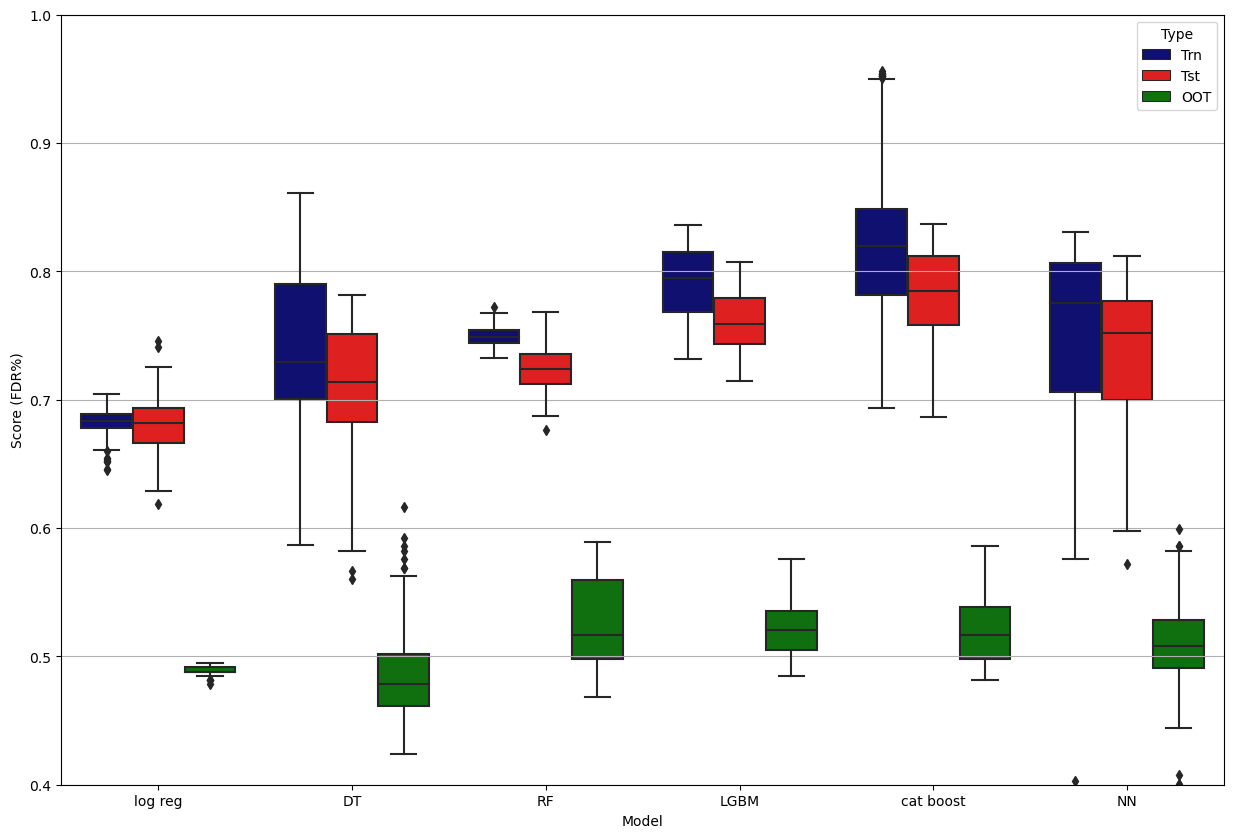

In [152]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
ax = sns.boxplot(x='Model',y='Value',hue='Type', data=df_compare, palette=['navy','r','g'])

plt.ylim(.4,1.)
plt.ylabel('Score (FDR%)')
plt.grid(axis='y')
plt.savefig('modeling.png')
plt.show()

In [153]:
print('duration: ', datetime.now() - start_time)

duration:  16:10:34.808999


In [ ]:
best_OOT

In [ ]:
best_OOT

# 7. Final Choice of model

The rest of the notebook makes the tables for my final model of choice. I need to run that final model only once (no CV).

### 1) Define a desired OOT FDR
- If the OOT FDR exceeds this value during any iteration, the loop will break, and that run will be selected as the final model.

In [187]:
%%time
# Note - need to set this next value to around the highest oot fdr for my model of choice.
# The model then runs a nombermof times with fixed hyperparameters until it finds a good model.
desire = .60
print('desire =', desire)

desire = 0.6
CPU times: user 311 µs, sys: 126 µs, total: 437 µs
Wall time: 405 µs


### 2) Training-testing split
- Each iteration starts with splitting the training data (X_trntst, Y_trntst) into training (X_trn, Y_trn) and testing (X_tst, Y_tst) sets.
- This step ensures that each iteration has a slightly different set of training and testing data due to the randomness of train_test_split.

In [188]:
for niter in range(50):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

### 3) Model Selection and training
- model = CatBoostClassifier(): model selection
-  model.fit(X_trn, Y_trn.values.ravel()): The model is trained on the training set (X_trn, Y_trn).

In [189]:
# Here's where I put my final model of choice.

model = CatBoostClassifier(
    subsample=0.7,               # Subsample rate (70%)
    max_depth=5,                 # Maximum tree depth (5)
    learning_rate=0.1,           # Learning rate (0.1)
    n_estimators=200,            # Number of trees (200)
    l2_leaf_reg=3,               # L2 regularization term (3)
    verbose=0                    # Silent mode (no output)
)

X_oot = X_oot_orig.copy()
X_trn_save = X_trn.copy()
Y_trn_save = Y_trn.copy()

model.fit(X_trn, Y_trn.values.ravel())   

### 4) Evaluate Training, Testing and OOT performace

### 5) Save results and breaking the loop
The loop breaks if the OOT FDR exceeds the desired threshold (.60). This ensures the model does not continue searching once a satisfactory OOT performance is found.
If no iteration reaches this criterion, the loop will complete all 60iterations.

In [ ]:
%%time
# Note - need to set this next value to around the highest oot fdr for my model of choice.
# The model then runs a nombermof times with the fixed hyperparameters until it finds a good model.
desire = .55
print('desire =', desire)
for niter in range(60):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = CatBoostClassifier(
        subsample=0.7,               # Subsample rate (70%)
        max_depth=5,                 # Maximum tree depth (5)
        learning_rate=0.1,           # Learning rate (0.1)
        n_estimators=200,            # Number of trees (200)
        l2_leaf_reg=3,               # L2 regularization term (3)
        verbose=0                    # Silent mode (no output)
    )

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
# choose a good break point
    if(FDR.loc[niter, 'oot'] > desire): break
    
model_counter = model_counter + 1

### 7) Copying the Training, Testing, and OOT Sets

In [202]:
X_trn_eval = X_trn.copy()
X_tst_eval = X_tst.copy()
X_oot_eval = X_oot.copy()

### 8) Creating DataFrames for Storing Evaluation Metrics

Here, three empty DataFrames (FDR_trn, FDR_tst, and FDR_oot) are created with 101 rows (corresponding to 101 bins or deciles) and 13 columns. These DataFrames will store the calculated metrics for the training, testing, and out-of-time datasets. The column names (cols) include:
- bin: The bin number (percentile of predicted scores).
- #recs: Number of records in each bin.
- #g: Number of good (non-fraud) records in each bin.
- #b: Number of bad (fraud) records in each bin.
- %g: Percentage of good records in the bin.
- %b: Percentage of bad records in the bin.
- tot: Total records in the bin.
- cg: Cumulative good records up to the current bin.
- cb: Cumulative bad records up to the current bin.
- %cg: Percentage of cumulative good records.
- FDR: Fraud Detection Rate (percentage of fraud cases detected).
- KS: Kolmogorov-Smirnov statistic (measuring the difference between the good and bad distributions).
- FPR: False Positive Rate (the rate of non-fraud cases being predicted as fraud).

In [260]:
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','%cg','FDR','KS','FPR']
FDR_trn = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_tst = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_oot = pd.DataFrame(np.zeros((101, 13)), columns = cols)
trn_sorted = X_trn_eval.sort_values('predicted',ascending=False)
tst_sorted = X_tst_eval.sort_values('predicted',ascending=False)
oot_sorted = X_oot_eval.sort_values('predicted',ascending=False)
bad_tot_trn = sum(X_trn_eval.loc[:, 'Fraud'])
bad_tot_tst = sum(X_tst_eval.loc[:, 'Fraud'])
bad_tot_oot = sum(X_oot_eval.loc[:, 'Fraud'])
num_tot_trn = len(X_trn_eval)
num_tot_tst = len(X_tst_eval)
num_tot_oot = len(X_oot_eval)
good_tot_trn = num_tot_trn - bad_tot_trn
good_tot_tst = num_tot_tst - bad_tot_tst
good_tot_oot = num_tot_oot - bad_tot_oot
oot_sorted.head(20)

,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60,Card_dow_vdratio_0by14,Merchnum_desc_State_total_3,Card_Merchdesc_total_7,Card_dow_unique_count_for_merch_zip_7,merch_state_total_1,predicted,Fraud
94031,7.900037,-0.324574,1.047494,-0.114619,1.512059,1.671754,-0.425850,-0.324642,5.198436,-0.437158,0.985037,1
96324,7.256559,-0.323033,1.369662,-0.188352,-0.637018,-0.753291,-0.173246,-0.323101,-0.503195,-0.435963,0.981861,1
88282,9.830472,-0.324023,1.879867,-0.266383,1.779675,1.598034,-0.425521,-0.324090,3.487946,-0.436731,0.976117,1
96458,8.543516,-0.325933,1.691996,-0.153790,2.689572,1.892914,-0.426661,-0.326001,2.917783,-0.438212,0.967768,1
94098,6.613081,-0.324328,0.439221,-0.114619,2.022315,1.892914,-0.425703,-0.324395,1.207294,-0.436967,0.961667,0
90122,-0.465180,12.941243,2.780150,1.493632,2.689572,1.892914,7.494529,12.940735,-0.503195,12.037138,0.960026,1
90115,-0.465180,12.690366,2.774478,1.493632,2.689572,1.892914,7.344743,12.689867,-0.503195,11.842592,0.960026,1
88288,9.830472,-0.325869,1.906733,-0.266383,1.855500,1.627522,-0.426623,-0.325936,4.058110,-0.438162,0.957649,1
95134,7.900037,-0.327758,0.494519,0.384712,1.607533,1.379252,-0.427751,-0.327825,10.690830,-0.439627,0.955854,1
90076,-0.465180,10.073697,2.718062,1.493632,-0.610452,-0.732159,5.782456,10.073284,-0.503195,9.035587,0.954353,1


### 9) Evaluate the performance of a fraud detection model at various thresholds of predicted fraud probability
- Setting Fraud and False Positive Costs
- Selecting the Top Rows Based on Predicted Fraud Scores
- Counting the Number of Fraud (Bad) and Non-Fraud (Good) Records in Each Bin
- Calculating Fraud Detection Rate (FDR) and Financial Impact

In [205]:
cost_fraud = 400
cost_fp = 20
for i in range(101):
    percent_rows_trn = int(round(X_trn_eval.shape[0]*0.01*i))
    percent_rows_tst = int(round(X_tst_eval.shape[0]*0.01*i))
    percent_rows_oot = int(round(X_oot_eval.shape[0]*0.01*i))
    temp_trn = trn_sorted.head(percent_rows_trn)
    temp_tst = tst_sorted.head(percent_rows_tst)
    temp_oot = oot_sorted.head(percent_rows_oot)
    num_bad_trn = sum(temp_trn.loc[:,'Fraud'])
    num_bad_tst = sum(temp_tst.loc[:,'Fraud'])
    num_bad_oot = sum(temp_oot.loc[:,'Fraud'])
    num_tot_trn = len(temp_trn)
    num_tot_tst = len(temp_tst)
    num_tot_oot = len(temp_oot)
    num_good_trn = num_tot_trn - num_bad_trn
    num_good_tst = num_tot_tst - num_bad_tst
    num_good_oot = num_tot_oot - num_bad_oot
    
    FDR_trn.loc[i, 'bin'] = i
    FDR_trn.loc[i,'#recs'] = 0
    FDR_trn.loc[i, 'tot'] = num_tot_trn
    FDR_trn.loc[i, 'cg'] = num_good_trn
    FDR_trn.loc[i, 'cb'] = num_bad_trn
    FDR_trn.loc[i, 'Fraud Savings'] = FDR_trn.loc[i, 'cb'] * cost_fraud
    FDR_trn.loc[i, 'FP Loss'] = FDR_trn.loc[i, 'cg'] * cost_fp
    FDR_trn.loc[i, 'Overall Savings'] = FDR_trn.loc[i, 'Fraud Savings'] - FDR_trn.loc[i, 'FP Loss']
    FDR_tst.loc[i, 'bin'] = i
    FDR_tst.loc[i, 'tot'] = num_tot_tst
    FDR_tst.loc[i, 'cg'] = num_good_tst
    FDR_tst.loc[i, 'cb'] = num_bad_tst
    FDR_tst.loc[i, 'Fraud Savings'] = FDR_tst.loc[i, 'cb'] * cost_fraud
    FDR_tst.loc[i, 'FP Loss'] = FDR_tst.loc[i, 'cg'] * cost_fp
    FDR_tst.loc[i, 'Overall Savings'] = FDR_tst.loc[i, 'Fraud Savings'] - FDR_tst.loc[i, 'FP Loss']
    FDR_oot.loc[i, 'bin'] = i
    FDR_oot.loc[i, 'tot'] = num_tot_oot
    FDR_oot.loc[i, 'cg'] = num_good_oot
    FDR_oot.loc[i, 'cb'] = num_bad_oot

    if i != 0:
        FDR_trn.loc[i, '#g'] = num_good_trn - FDR_trn.loc[i-1, 'cg']
        FDR_trn.loc[i, '#b'] = num_bad_trn - FDR_trn.loc[i-1, 'cb']
        FDR_trn.loc[i,'#recs'] = FDR_trn.loc[i, '#g'] + FDR_trn.loc[i, '#b']
        FDR_trn.loc[i, '%g'] = 100* (num_good_trn - FDR_trn.loc[i-1, 'cg']) / (num_tot_trn - FDR_trn.loc[i-1, 'tot'])
        FDR_trn.loc[i, '%b'] = 100 - FDR_trn.loc[i, '%g']
        FDR_trn.loc[i, '%cg'] = 100 * num_good_trn / good_tot_trn
        FDR_trn.loc[i, 'FDR'] = 100 * num_bad_trn / bad_tot_trn
        FDR_trn.loc[i, 'KS'] = FDR_trn.loc[i, 'FDR'] - FDR_trn.loc[i, '%cg']
        FDR_trn.loc[i, 'FPR'] = num_good_trn / num_bad_trn
        FDR_tst.loc[i, '#g'] = num_good_tst - FDR_tst.loc[i-1, 'cg']
        FDR_tst.loc[i, '#b'] = num_bad_tst - FDR_tst.loc[i-1, 'cb']
        FDR_tst.loc[i,'#recs'] = FDR_tst.loc[i, '#g'] + FDR_tst.loc[i, '#b']
        FDR_tst.loc[i, '%g'] = 100* (num_good_tst - FDR_tst.loc[i-1, 'cg']) / (num_tot_tst - FDR_tst.loc[i-1, 'tot'])
        FDR_tst.loc[i, '%b'] = 100 - FDR_tst.loc[i, '%g']
        FDR_tst.loc[i, '%cg'] = 100 * num_good_tst / good_tot_tst
        FDR_tst.loc[i, 'FDR'] = 100 * num_bad_tst / bad_tot_tst
        FDR_tst.loc[i, 'KS'] = FDR_tst.loc[i, 'FDR'] - FDR_tst.loc[i, '%cg']
        FDR_tst.loc[i, 'FPR'] = num_good_tst / num_bad_tst
        FDR_oot.loc[i, '#g'] = num_good_oot - FDR_oot.loc[i-1, 'cg']
        FDR_oot.loc[i, '#b'] = num_bad_oot - FDR_oot.loc[i-1, 'cb']
        FDR_oot.loc[i,'#recs'] = FDR_oot.loc[i, '#g'] + FDR_oot.loc[i, '#b']
        FDR_oot.loc[i, '%g'] = 100* (num_good_oot - FDR_oot.loc[i-1, 'cg']) / (num_tot_oot - FDR_oot.loc[i-1, 'tot'])
        FDR_oot.loc[i, '%b'] = 100 - FDR_oot.loc[i, '%g']
        FDR_oot.loc[i, '%cg'] = 100 * num_good_oot / good_tot_oot
        FDR_oot.loc[i, 'FDR'] = 100 * num_bad_oot / bad_tot_oot
        FDR_oot.loc[i, 'KS'] = FDR_oot.loc[i, 'FDR'] - FDR_oot.loc[i, '%cg']
        FDR_oot.loc[i, 'FPR'] = num_good_oot / num_bad_oot

FDR_oot

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,%cg,FDR,KS,FPR
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,1.0,122.0,27.0,95.0,22.131148,77.868852,122.0,27.0,95.0,0.226225,31.986532,31.760307,0.284211
2,2.0,123.0,79.0,44.0,64.227642,35.772358,245.0,106.0,139.0,0.888144,46.801347,45.913203,0.762590
3,3.0,122.0,96.0,26.0,78.688525,21.311475,367.0,202.0,165.0,1.692501,55.555556,53.863055,1.224242
4,4.0,122.0,104.0,18.0,85.245902,14.754098,489.0,306.0,183.0,2.563888,61.616162,59.052274,1.672131
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,123.0,123.0,0.0,100.000000,0.000000,11743.0,11446.0,297.0,95.902807,100.000000,4.097193,38.538721
97,97.0,122.0,122.0,0.0,100.000000,0.000000,11865.0,11568.0,297.0,96.925010,100.000000,3.074990,38.949495
98,98.0,122.0,122.0,0.0,100.000000,0.000000,11987.0,11690.0,297.0,97.947214,100.000000,2.052786,39.360269
99,99.0,123.0,123.0,0.0,100.000000,0.000000,12110.0,11813.0,297.0,98.977796,100.000000,1.022204,39.774411


# [Financial Analysis]

### 1) Evaluate the financial impact of fraud detection at different thresholds, showing how the savings from fraud detection compare to the losses from fasle positives, identify the threshold that maximizes overall savings
- Scaling Factor Calculation: The sample contains data from 2 months (out of 12 months) and covers 100,000 transactions (out of 10 million). Thus, the scaling factor adjusts the savings and losses to reflect the entire dataset, scaling the sample performance by the ratio of the full dataset to the sample size.
- Fraud Savings: Total savings from detecting fraud at each threshold.
- FP Loss: Losses due to false positives (misclassified non-fraud transactions).
- Overall Savings: The difference between Fraud Savings and FP Loss.
- Finding Maximum Possible Savings

Max possible savings: 47,184,000.0


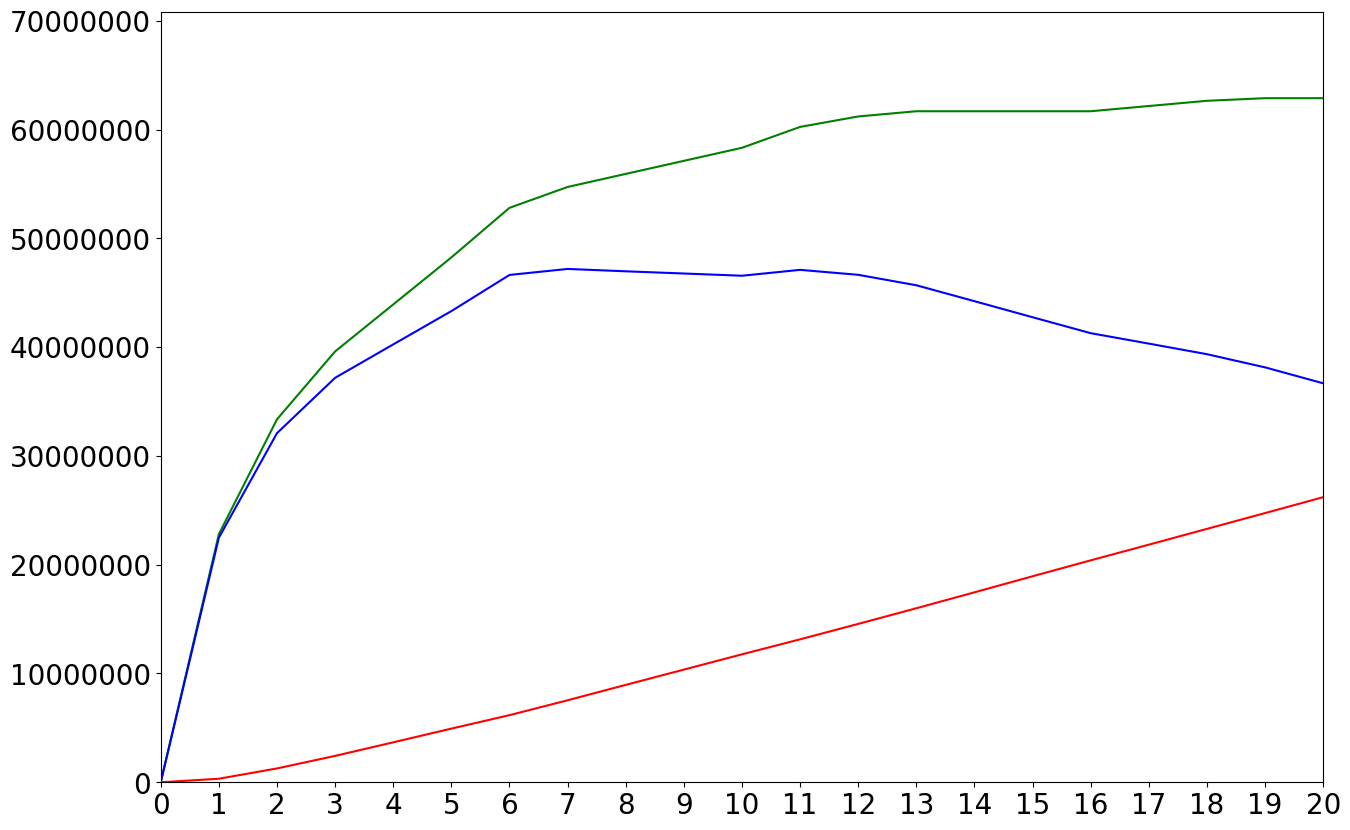

In [206]:
# xmult: oot is only 2 out of 12 months. 100,000 sample transactions out of 10 million/year
xoot = 12/2 * 10000000/100000
Financials_trn = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
Financials_tst = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
Financials_oot = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
for i in range(101):
    Financials_trn.loc[i, 'Fraud Savings'] = FDR_trn.loc[i, 'cb'] * cost_fraud * xoot
    Financials_trn.loc[i, 'FP Loss'] = FDR_trn.loc[i, 'cg'] * cost_fp * xoot
    Financials_trn.loc[i, 'Overall Savings'] = Financials_trn.loc[i, 'Fraud Savings'] - Financials_trn.loc[i, 'FP Loss']
    Financials_tst.loc[i, 'Fraud Savings'] = FDR_tst.loc[i, 'cb'] * cost_fraud * xoot
    Financials_tst.loc[i, 'FP Loss'] = FDR_tst.loc[i, 'cg'] * cost_fp * xoot
    Financials_tst.loc[i, 'Overall Savings'] = Financials_tst.loc[i, 'Fraud Savings'] - Financials_tst.loc[i, 'FP Loss']
    Financials_oot.loc[i, 'Fraud Savings'] = FDR_oot.loc[i, 'cb'] * cost_fraud * xoot
    Financials_oot.loc[i, 'FP Loss'] = FDR_oot.loc[i, 'cg'] * cost_fp * xoot
    Financials_oot.loc[i, 'Overall Savings'] = Financials_oot.loc[i, 'Fraud Savings'] - Financials_oot.loc[i, 'FP Loss']

max_savings = Financials_oot['Overall Savings'].max(0)
print('Max possible savings: '+'{:,}'.format(max_savings))
yupper = max_savings * 1.5
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(15,10))
plt.plot(Financials_oot['Fraud Savings'], color='green')
plt.plot(Financials_oot['FP Loss'], color='red')
plt.plot(Financials_oot['Overall Savings'], color='blue')
xlimit = 20
interval = 1
plt.xlim(0,xlimit)
plt.ylim(0,yupper)
plt.xticks(ticks=np.linspace(0,xlimit, num=int(xlimit/interval)+1))
plt.ticklabel_format(style='plain')
plt.savefig('savings.png', format='png')

### 2) Setting the Score cutoff 
- Fraud Savings Suggests Score Cutoff: I want to deny as few as possible, but also to get good overall savings. Don’t need to use the “best” point, but smallest cutoff that still is close to the highest savings.
- Choosing bin 6 as a cutoff means that the business will take action (e.g., flagging transactions or denying access) on the top 6% of the highest-risk transactions based on the model’s fraud score. Here’s what this means for the business.
- Bin 6 means that I'm looking at the top 6% of transactions ranked by the model's predicted probability of fraud. The model sorts all transactions from the most likely to be fraudulent to the least likely, and bin 6 represents the transactions that fall within the top 6% most likely to be fraudulent.
- In my plot, bin 6 would give the business fraud savings from preventing fraudulent transactions but also false positive losses from flagging legitimate transactions. By choosing bin 6, I am accepting a balance between catching enough fraud and avoiding the cost of too many false positives. The business will save money on fraud losses by flagging transactions, but it will also incur some cost by inconveniencing legitimate customers.
- For the business, choosing bin 6 means it will focus resources on the top 6% of high-risk transactions. It’s a middle ground, aiming to maximize savings while keeping customer inconvenience (false positives) to a minimum. The business might decide that acting on the top 6% strikes the right balance between detecting fraud and maintaining a good customer experience. Flagging more (higher bins) could lead to higher false positives, while flagging less (lower bins) might miss more fraud.

In [207]:
FDR_oot.head(10)

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,%cg,FDR,KS,FPR
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,1.0,122.0,27.0,95.0,22.131148,77.868852,122.0,27.0,95.0,0.226225,31.986532,31.760307,0.284211
2,2.0,123.0,79.0,44.0,64.227642,35.772358,245.0,106.0,139.0,0.888144,46.801347,45.913203,0.762590
3,3.0,122.0,96.0,26.0,78.688525,21.311475,367.0,202.0,165.0,1.692501,55.555556,53.863055,1.224242
4,4.0,122.0,104.0,18.0,85.245902,14.754098,489.0,306.0,183.0,2.563888,61.616162,59.052274,1.672131
5,5.0,123.0,105.0,18.0,85.365854,14.634146,612.0,411.0,201.0,3.443653,67.676768,64.233115,2.044776
6,6.0,122.0,103.0,19.0,84.426230,15.573770,734.0,514.0,220.0,4.306661,74.074074,69.767413,2.336364
7,7.0,122.0,114.0,8.0,93.442623,6.557377,856.0,628.0,228.0,5.261835,76.767677,71.505842,2.754386
8,8.0,123.0,118.0,5.0,95.934959,4.065041,979.0,746.0,233.0,6.250524,78.451178,72.200655,3.201717
9,9.0,122.0,117.0,5.0,95.901639,4.098361,1101.0,863.0,238.0,7.230834,80.134680,72.903846,3.626050


In [208]:
FDR.to_csv('FDR.csv')

In [209]:
FDR_trn.to_csv('FDR_trn.csv', index=False)
FDR_tst.to_csv('FDR_tst.csv', index=False)
FDR_oot.to_csv('FDR_oot.csv', index=False)

In [210]:
Metrics = FDR_oot.copy()
num_good = Metrics['#g'].sum()
num_bad = Metrics['#b'].sum()
num_tot = Metrics['#recs'].sum()
print(num_good,num_bad,num_good+num_bad,num_tot)

11935.0 297.0 12232.0 12232.0


In [211]:
Metrics['TP'] = Metrics['cb']
Metrics['TN'] = num_good - Metrics['cg']
Metrics['FN'] = num_bad - Metrics['cb']
Metrics['FP'] = Metrics['cg']
Metrics['Accuracy'] = (Metrics['TP'] + Metrics['TN']) / num_tot
Metrics['Misclass'] = (Metrics['FP'] + Metrics['FN']) / num_tot
Metrics['FPRate'] = Metrics['FP'] / (Metrics['FP'] + Metrics['TN'])
Metrics['FPRatio'] = Metrics['FP'] / Metrics['TP']
Metrics['TPR'] = Metrics['TP'] / (Metrics['TP'] + Metrics['FN'])
Metrics['TNR'] = Metrics['TN'] / (Metrics['TN'] + Metrics['FP'])
Metrics['Precision'] = Metrics['TP'] / (Metrics['TP'] + Metrics['FP'])
Metrics['f1'] = 2 * Metrics['Precision'] * Metrics['TPR'] / (Metrics['Precision'] + Metrics['TPR'])
Metrics.to_csv('Metrics.csv')

Text(0, 0.5, 'FDR')

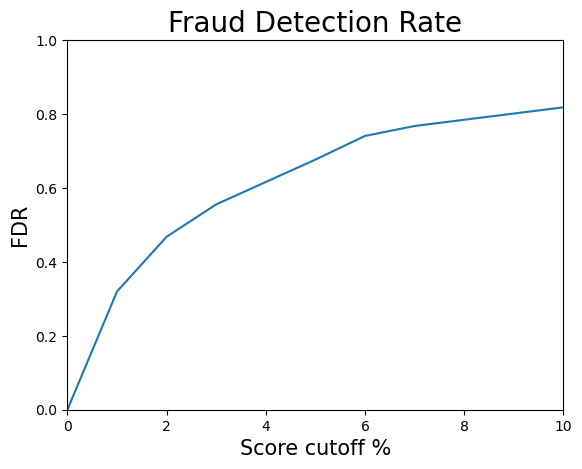

In [212]:
plt.rcParams.update({'font.size':10})
plt.plot(Metrics['bin'], Metrics['TPR'])
plt.title('Fraud Detection Rate', fontsize=20)
plt.xlim(0,10)
plt.ylim(0,1)
plt.xlabel('Score cutoff %', fontsize=15)
plt.ylabel('FDR', fontsize=15)

### 3) ROC curve
- ROC (Receiver Operating Characteristic) curve is a plot of the True Positive Rate (TPR) against the False Positive Rate (FPR) across various threshold values. It is used to evaluate the performance of a classification model, especially in terms of its ability to distinguish between positive (fraud) and negative (non-fraud) classes.
- True Positive Rate (TPR) – Y-Axis: The TPR, also called Recall or Sensitivity, is the proportion of actual positives (fraud cases) that the model correctly identifies as positive. In this plot, the TPR increases as the cutoff threshold lowers, which is expected because the model becomes more lenient in labeling transactions as fraud, thus identifying more true fraud cases. A TPR close to 1 means the model is capturing almost all fraud cases.
- False Positive Rate (FPR) – X-Axis: The FPR represents the proportion of actual negatives (non-fraud cases) that are incorrectly classified as fraud. A high FPR means the model is falsely flagging many legitimate transactions as fraud. In this plot, as the threshold is lowered, the FPR increases, meaning more legitimate transactions are incorrectly classified as fraud. This is typical because as I lower the score cutoff, i catch more fraud (increase TPR), but at the expense of also flagging more legitimate cases (increase FPR).

(0.0, 1.0)

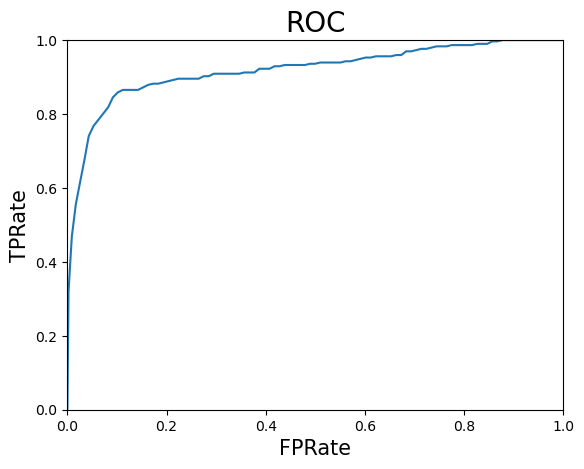

In [213]:
plt.plot(Metrics['FPRate'], Metrics['TPR'])
plt.title('ROC', fontsize=20)
plt.xlabel('FPRate',fontsize=15)
plt.ylabel('TPRate', fontsize=15)
plt.xlim(0,1)
plt.ylim(0,1)

- A good ROC curve should be close to the top-left corner (where TPR is high and FPR is low), indicating that the model is capable of identifying most fraud cases with minimal false positives.
- In this case, the model appears to be performing well, but there is a tradeoff: as I lower the score cutoff to capture more fraud (increase TPR), I also increase the risk of false positives (flagging legitimate customers as fraud). This would mean increased operational costs in terms of reviewing flagged transactions and potentially harming the customer experience.
- The ROC curve provides a visual evaluation of the model's ability to distinguish between fraud and non-fraud transactions. The business would aim to set a threshold that maximizes the TPR while keeping the FPR at an acceptable level, ensuring that legitimate transactions are not unnecessarily flagged, but fraud is still effectively detected. The model’s performance looks solid based on this curve, but the exact threshold choice should align with the company's risk tolerance and operational capacity.

In [214]:
print("duration: ", datetime.now() - start_time)

duration:  0:20:02.932133


In [217]:
%%time
df = pd.read_csv('card transactions.csv')
df.dropna(how='all', axis=1, inplace=True)
df = df[df['Transtype'] == 'P']
df = df[df['Amount'] <= 3000000]
df['Date'] = pd.to_datetime(df['Date'])
df.shape

CPU times: user 139 ms, sys: 27.8 ms, total: 166 ms
Wall time: 165 ms


(97496, 10)

In [218]:
df['prediction'] = model.predict_proba(X)[:,1]

In [219]:
pred_scale = 1/df['prediction'].max()
df['prediction'] = df['prediction']*pred_scale

In [220]:
df.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,prediction
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,0.000366
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,0.000298
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,0.001974
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,0.000366
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,0.001296


In [221]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97496 entries, 0 to 97851
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Recnum             97496 non-null  int64         
 1   Cardnum            97496 non-null  int64         
 2   Date               97496 non-null  datetime64[ns]
 3   Merchnum           94276 non-null  object        
 4   Merch description  97496 non-null  object        
 5   Merch state        96468 non-null  object        
 6   Merch zip          93149 non-null  float64       
 7   Transtype          97496 non-null  object        
 8   Amount             97496 non-null  float64       
 9   Fraud              97496 non-null  int64         
 10  prediction         97496 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(4)
memory usage: 8.9+ MB


In [222]:
df_sorted = df.sort_values(by=['prediction'],ascending=False)
df_sorted.head(20)

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,prediction
71546,71547,5142220919,2010-09-06,5859560900441,O'BRIEN PARTITION CO,MO,64130.0,P,6070.31,1,1.000000
42827,42828,5142111125,2010-06-06,9900000037306,GSA/CUST SUPPLY CTR 97,GA,30268.0,P,5084.25,1,0.999895
42704,42705,5142111125,2010-06-06,4620006363548,GATEWAY BUSINESS DIRECT,SD,57049.0,P,5859.05,1,0.999823
71551,71552,5142220919,2010-09-06,467590957335,VAN PRODUCTS INC,NC,27604.0,P,4758.33,1,0.999757
42584,42585,5142111125,2010-06-06,4620009750086,RUPPRECHT & PATASHNICK CO,NY,12203.0,P,5309.08,1,0.999692
20883,20884,5142214614,2010-03-21,602608964157,GTSI,VA,20151.0,P,5041.22,1,0.999592
20845,20846,5142214614,2010-03-21,674615479337,EGGHEAD WWW.EGGHEAD.COM,CA,94025.0,P,4345.53,1,0.999313
71398,71399,5142220919,2010-09-06,991904668332,KEY DATA SYSTEMS,CA,91406.0,P,4665.02,1,0.998772
71424,71425,5142220919,2010-09-06,6848556518938,CALBIOCHEM-NOVABIOCHEM CO,CA,92121.0,P,4913.75,1,0.998772
20798,20799,5142214614,2010-03-21,5933400526666,XEROX CAC1,CT,6907.0,P,4085.38,1,0.998512


# 9.  Fraud Score Dynamics
- Here I am going to look at specific cards or merchants to look at the dynamics of the fraud score

In [223]:
bads = df[df['Fraud']==1]
bads['Cardnum'].value_counts().head(20)

5142214614    60
5142271065    58
5142140316    46
5142847398    45
5142199009    45
5142219623    44
5142189341    41
5142160778    41
5142225942    41
5142212038    39
5142181728    39
5142220919    38
5142165136    37
5142202847    37
5142138135    36
5142223659    36
5142149994    35
5142226204    35
5142260253    34
5142189108    33
Name: Cardnum, dtype: int64

In [224]:
bads['Merchnum'].value_counts().head(15)

930090121224     151
4353000719908    116
9108234610000     48
8834000695423     46
4503738417400     45
9900020006406     43
4620009957157     41
4503082476300     39
618901687330      36
900009045549      36
253052983001      34
938909877224      32
6006333528866     30
997674930332      30
6070095870009     27
Name: Merchnum, dtype: int64

In [225]:
card = 5142140316
# card = 5142847398
# card = 5142199009
# card = 5142160778
# card = 5142189341
# card = 5142181728
# card = 5142212038
# card = 5142220919
# card = 5142214614
# card = 5142202847
# card = 5142138135
# card = 5142271065
# card = 5142152857
# card = 5142179617
# card = 5142235211
# card = 5142197711
# card = 5142182128
# card = 5142189113
# card = 5142197563 

merch = 4353000719908
# merch = 930090121224  
# merch = 48834000695423
# merch = 44503738417400
# merch = 44620009957157
# merch = 4618901687330
# merch = 4900009045549
# merch = 49108234610000
# merch = 4253052983001
# merch = 4938909877224
# merch = 44503082476300
# merch = 46006333528866
# merch = 4997674930332
# merch = 46070095870009
# merch = 49900020006406
sample = df[df['Cardnum'] == card]
# sample = df[df['Merchnum'] == str(merch)]
sample['Fraud'].sum()

46

### 1) Fraudulent Behavior Timing

- X-axis (Dates): The X-axis represents time, showing transaction dates from January 2010 to January 2011.
- Y-axis (Fraud Score/Fraud Indicator):1 typically represents a high likelihood or certainty of fraud. 0 indicates no fraud or very low suspicion of fraud. The orange dots represent actual fraud occurrences.
- Blue Line (Predicted Fraud Scores): This line represents the model's prediction for each transaction, indicating the likelihood of fraud. For example, if the score approaches 1, the model strongly suspects fraud. The spikes in the blue line in the middle (July to September 2010) show a sudden increase in the predicted fraud score, which may correspond to periods when fraudulent transactions were more likely to occur.
-  Orange Dots (Actual Fraud Occurrences): The orange dots represent actual fraudulent transactions (when Fraud == 1). Notice that there are many orange dots concentrated in the July-September 2010 period, which suggests this time frame had a high incidence of fraud for this particular card or merchant.

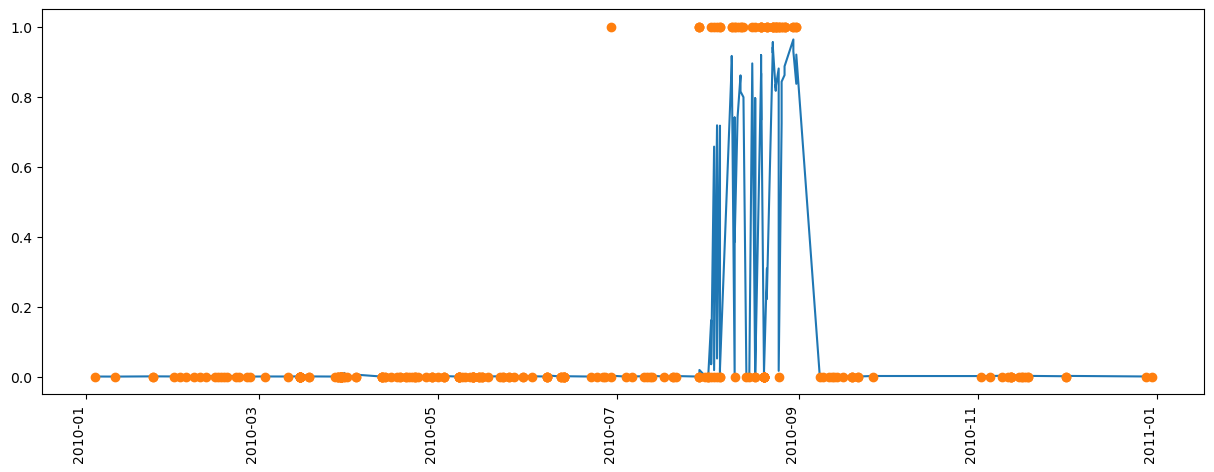

In [226]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90, ha='right')
plt.plot(sample['Date'],sample['prediction'])
plt.plot_date(sample['Date'],sample['Fraud'])

Key Observations:
- Periods of high fraud detection: From July to September 2010, I can observe frequent fraud incidents (orange dots) and corresponding spikes in the model’s fraud prediction scores (blue line). This suggests that during this period, the model was able to correctly identify most of the fraudulent transactions.
- False Negatives: In earlier parts of the year (January to May), some orange dots are present, but the model’s prediction (blue line) is close to 0. This indicates that the model did not recognize these transactions as fraudulent despite them being fraud, potentially representing false negatives.
- Missed Opportunities: Before July 2010, the model did not predict many fraudulent activities (no spikes), even though there were some fraudulent transactions, indicating that the model was less sensitive to fraud during this time frame.

In [227]:
tsample = sample[sample['Date'] > '2010-08-01']
tsample = tsample[tsample['Date'] < '2010-09-10']
tsample.reset_index(inplace=True)
tsample.reset_index(inplace=True)
tsample.rename(columns={'level_0':'counter'},inplace=True)
tsample['counter'] = tsample['counter']+1
tsample.head()

,counter,index,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,prediction
0,1,59430,59431,5142140316,2010-08-02,8834000695423,STEVES COMPUTER REPAIR,CA,92656.0,P,2629.20,1,0.161089
1,2,59776,59777,5142140316,2010-08-02,4620002006336,HP GSA STORE,AZ,85285.0,P,644.00,0,0.035393
2,3,59886,59887,5142140316,2010-08-03,8834000695423,STEVES COMPUTER REPAIR,CA,92656.0,P,560.72,1,0.657233
3,4,60227,60228,5142140316,2010-08-03,465906341338,HEWLETT PACKARD CO,CA,95747.0,P,176.00,0,0.018593
4,5,60345,60346,5142140316,2010-08-04,8834000695423,STEVES COMPUTER REPAIR,CA,92656.0,P,487.26,1,0.718149


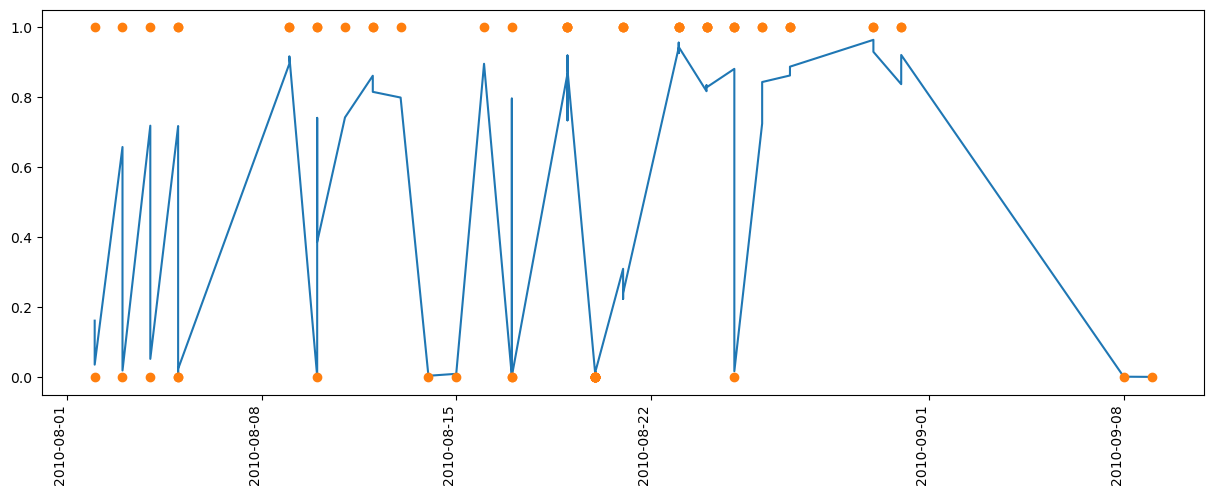

In [228]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90, ha='right')
plt.plot(tsample['Date'],tsample['prediction'])
plt.plot_date(tsample['Date'],tsample['Fraud'])
plt.savefig('dynamics_time.png', format='png')

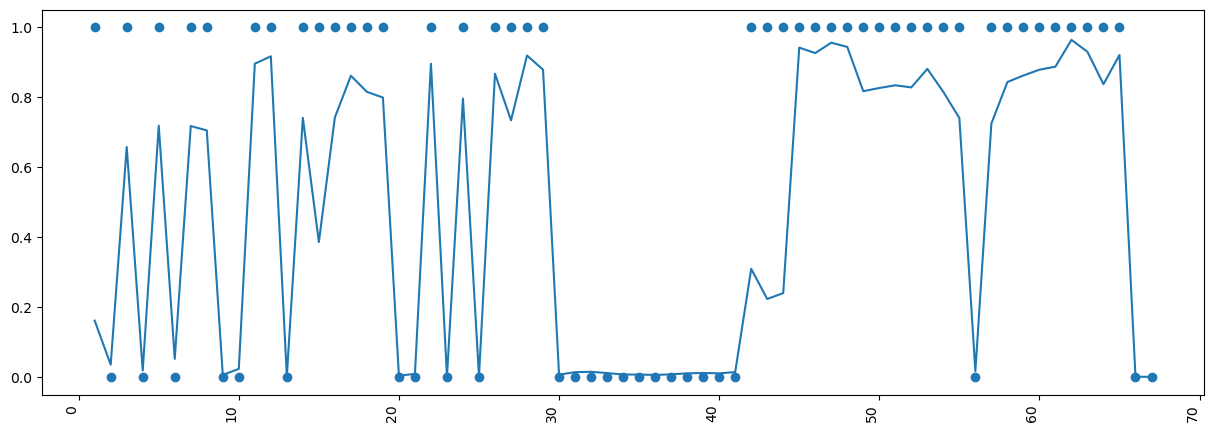

In [229]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90, ha='right')
plt.plot(tsample['counter'],tsample['prediction'])
plt.scatter(tsample['counter'],tsample['Fraud'])
plt.savefig('dynamics_count.png', format='png')

- y axis (Counter): This was created in my code to assign a sequential identifier to each transaction after I filtered the transactions between August 1, 2010, and September 10, 2010. So, each point on the x-axis represents an individual transaction in the order it appeared during that period.

In [230]:
tsample.to_csv('dynamics_transactions.csv')
tsample.head(40)

,counter,index,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,prediction
0,1,59430,59431,5142140316,2010-08-02,8834000695423,STEVES COMPUTER REPAIR,CA,92656.0,P,2629.20,1,0.161089
1,2,59776,59777,5142140316,2010-08-02,4620002006336,HP GSA STORE,AZ,85285.0,P,644.00,0,0.035393
2,3,59886,59887,5142140316,2010-08-03,8834000695423,STEVES COMPUTER REPAIR,CA,92656.0,P,560.72,1,0.657233
3,4,60227,60228,5142140316,2010-08-03,465906341338,HEWLETT PACKARD CO,CA,95747.0,P,176.00,0,0.018593
4,5,60345,60346,5142140316,2010-08-04,8834000695423,STEVES COMPUTER REPAIR,CA,92656.0,P,487.26,1,0.718149
5,6,60640,60641,5142140316,2010-08-04,4620002006336,HP GSA STORE,AZ,85285.0,P,1060.00,0,0.051856
6,7,60688,60689,5142140316,2010-08-05,8834000695423,STEVES COMPUTER REPAIR,CA,92656.0,P,629.09,1,0.717104
7,8,60691,60692,5142140316,2010-08-05,8834000695423,STEVES COMPUTER REPAIR,CA,92656.0,P,1821.05,1,0.704674
8,9,60758,60759,5142140316,2010-08-05,930090121224,FEDEX SHP 07/24/10 AB#,TN,38118.0,P,5.16,0,0.006051
9,10,60792,60793,5142140316,2010-08-05,930090121224,FEDEX SHP 07/21/10 AB#,TN,38118.0,P,3.57,0,0.023259


In [231]:
len(tsample)

67

# 10. Score Calibration
- Score calibration is the process of adjusting the raw prediction scores of a machine learning model so that they can be interpreted as well-calibrated probabilities. In other words, if a model predicts a fraud probability of 0.7, after calibration, it means that 70% of the time, the transactions with this predicted score are indeed fraudulent. Without calibration, the raw scores may not reflect true probabilities, even if the ranking of predictions is accurate. I need to transform the score into the odds of being bad. This transformation process is called score calibration.
- Business Example in Fraud Detection: If a fraud model predicts a score of 0.75 for a transaction, after score calibration, I want this 0.75 to mean that 75% of the time, similar transactions actually turned out to be fraud. This helps businesses accurately gauge the risk and optimize their responses (e.g., investigating a suspicious transaction or blocking it). In summary, score calibration is crucial to making the model's predictions more reliable and interpretable, especially when working with probability-based decisions.

In [232]:
base = 600
delta = 20
odds_at_base = .1

In [233]:
df = pd.concat([X_trn_eval,X_tst_eval,X_oot_eval])
df.shape

(97496, 12)

In [234]:
df.head()

,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60,Card_dow_vdratio_0by14,Merchnum_desc_State_total_3,Card_Merchdesc_total_7,Card_dow_unique_count_for_merch_zip_7,merch_state_total_1,predicted,Fraud
83934,0.178299,2.131665,-0.169052,0.103377,-0.613353,-0.707928,0.476881,2.131516,-0.503195,-0.079817,0.017859,0
72579,-0.465180,0.267342,-0.961221,0.702034,0.020541,1.008274,-0.072445,0.267255,0.066968,0.021853,0.004809,0
83024,-0.465180,-0.331680,0.936899,-0.714211,-0.628485,-0.746504,-0.430093,-0.331747,-0.503195,-0.442669,0.000225,0
23643,0.178299,-0.264633,1.335041,-0.426652,-0.591111,-0.672542,0.462962,-0.264703,-0.503195,0.394331,0.003506,0
11808,0.178299,-0.260561,-0.788384,-0.007455,-0.133441,0.565954,-0.387631,-0.260631,0.637131,-0.387519,0.001684,0


In [235]:
calib = df.iloc[:,df.shape[1]-2:]
trn_sorted = X_trn_eval.sort_values('predicted',ascending=True)
calib = calib.sort_values('predicted')
calib.rename(columns={'predicted':'score_raw'}, inplace=True)
calib['score_raw'].clip(upper=.999, inplace=True)
calib['score_raw'].clip(lower=.00001, inplace=True)
calib.head()

,score_raw,Fraud
75395,0.000030,0
78666,0.000033,0
35826,0.000034,0
54173,0.000036,0
66936,0.000039,0


In [236]:
calib.shape

(97496, 2)

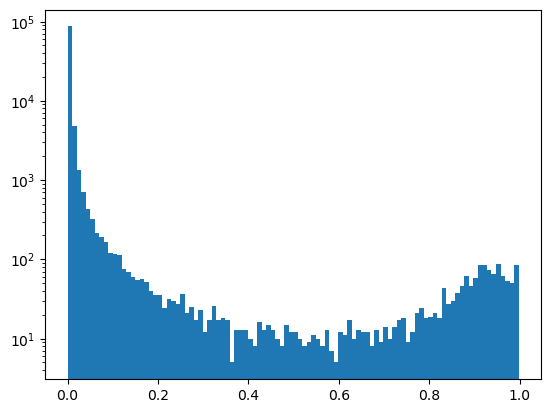

In [237]:
plt.hist(calib['score_raw'],bins=100)
plt.yscale('log')

In [238]:
# The reason I bin the records is to calculate the odds. I can then find the relationship between the raw score and the log odds.
nbins=100
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','score_raw','prob(%)','odds','log_odds', 'log_odds_adj']
cal_bins = pd.DataFrame(np.zeros((nbins+1, 14)), columns = cols)

In [239]:
bad_tot = sum(calib.loc[:, 'Fraud'])
good_tot = len(calib) - bad_tot
print(bad_tot, good_tot)

2047 95449


In [240]:
frac = 1/nbins
nrecs = calib.shape[0]
cal_bins.loc[0,'log_odds_adj'] = -8
for i in range(nbins+1):
    percent_rows_top = int(round(nrecs*frac*i))
    percent_rows_bottom = max(int(round(nrecs*frac*(i-1))),0)
    temp = calib.iloc[percent_rows_bottom:percent_rows_top,:]
    cal_bins.loc[i, 'score_raw'] = temp['score_raw'].mean()
    num_bad = int(sum(temp.loc[:,'Fraud']))
    num_tot = len(temp) * i
    num_good = int(num_tot - num_bad)
    cal_bins.loc[i, 'bin'] = i
    cal_bins.loc[i,'#recs'] = 0
    cal_bins.loc[i, 'tot'] = num_tot
    cal_bins.loc[i, 'cg'] = num_good
    cal_bins.loc[i, 'cb'] = num_bad
    if i != 0:
        cal_bins.loc[i, '#recs'] = len(temp)
        cal_bins.loc[i, '#b'] = int(sum(temp.loc[:, 'Fraud']))
        cal_bins.loc[i, '#g'] = cal_bins.loc[i, '#recs'] - cal_bins.loc[i, '#b']
        cal_bins.loc[i, '%g'] = 100* cal_bins.loc[i, '#g'] / cal_bins.loc[i, '#recs']
        cal_bins.loc[i, '%b'] = 100 - cal_bins.loc[i, '%g']
        cal_bins.loc[i, 'cg'] = cal_bins.loc[i-1, 'cg'] + cal_bins.loc[i, '#g']
        cal_bins.loc[i, 'cb'] = cal_bins.loc[i-1, 'cb'] + cal_bins.loc[i, '#b']
        cal_bins.loc[i, 'prob(%)'] = 100 * cal_bins.loc[i, '#b'] / cal_bins.loc[i, '#recs']
        cal_bins.loc[i, 'odds'] = (cal_bins.loc[i, '#b'] + .001) / cal_bins.loc[i, '#g']
        cal_bins.loc[i, 'log_odds'] = np.log2(cal_bins.loc[i, 'odds'])
        cal_bins.loc[i, 'log_odds_adj'] = max(cal_bins.loc[i, 'log_odds'], cal_bins.loc[i-1, 'log_odds_adj'])
        
cal_bins.drop(index=0,axis=0,inplace=True)
cal_bins.fillna(0)

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,score_raw,prob(%),odds,log_odds,log_odds_adj
1,1.0,975.0,975.0,0.0,100.000000,0.000000,975.0,975.0,0.0,0.000110,0.000000,0.000001,-19.895043,-8.000000
2,2.0,975.0,975.0,0.0,100.000000,0.000000,1950.0,1950.0,0.0,0.000168,0.000000,0.000001,-19.895043,-8.000000
3,3.0,975.0,975.0,0.0,100.000000,0.000000,2925.0,2925.0,0.0,0.000207,0.000000,0.000001,-19.895043,-8.000000
4,4.0,975.0,975.0,0.0,100.000000,0.000000,3900.0,3900.0,0.0,0.000244,0.000000,0.000001,-19.895043,-8.000000
5,5.0,975.0,975.0,0.0,100.000000,0.000000,4875.0,4875.0,0.0,0.000283,0.000000,0.000001,-19.895043,-8.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,975.0,919.0,56.0,94.256410,5.743590,93600.0,93238.0,358.0,0.035271,5.743590,0.060937,-4.036540,-4.036540
97,97.0,975.0,897.0,78.0,92.000000,8.000000,94575.0,94135.0,436.0,0.058632,8.000000,0.086958,-3.523543,-3.523543
98,98.0,975.0,848.0,127.0,86.974359,13.025641,95550.0,94983.0,563.0,0.125179,13.025641,0.149765,-2.739224,-2.739224
99,99.0,975.0,418.0,557.0,42.871795,57.128205,96525.0,95401.0,1120.0,0.491993,57.128205,1.332538,0.414177,0.414177


In [241]:
cal_bins.tail()

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,score_raw,prob(%),odds,log_odds,log_odds_adj
96,96.0,975.0,919.0,56.0,94.256410,5.743590,93600.0,93238.0,358.0,0.035271,5.743590,0.060937,-4.036540,-4.036540
97,97.0,975.0,897.0,78.0,92.000000,8.000000,94575.0,94135.0,436.0,0.058632,8.000000,0.086958,-3.523543,-3.523543
98,98.0,975.0,848.0,127.0,86.974359,13.025641,95550.0,94983.0,563.0,0.125179,13.025641,0.149765,-2.739224,-2.739224
99,99.0,975.0,418.0,557.0,42.871795,57.128205,96525.0,95401.0,1120.0,0.491993,57.128205,1.332538,0.414177,0.414177
100,100.0,975.0,48.0,927.0,4.923077,95.076923,97500.0,95449.0,2047.0,0.924950,95.076923,19.312521,4.271465,4.271465


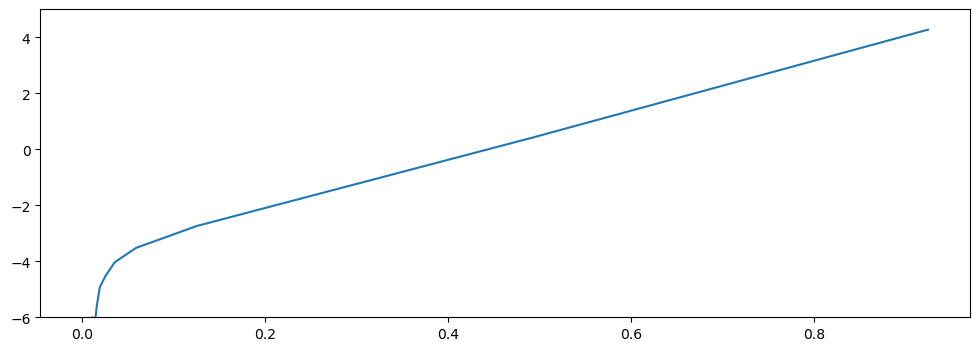

In [242]:
plt.figure(figsize=(12,4))
plt.ylim([-6,5])
plt.plot(cal_bins['score_raw'],cal_bins['log_odds'])
# plt.plot(cal_bins['score_raw'],cal_bins['log_odds_adj'])
# plt.xlim([0,1])

In [243]:
def funcg(x, a, b, c):
    return c + b/(1 + np.exp(-a * x))

def funcf(x, a, b, c):
    return -np.log(-1 + b/(x - c))/a

In [244]:
from scipy.optimize import curve_fit
popt, pcov = curve_fit(funcg, cal_bins['log_odds_adj'],cal_bins['score_raw'])   
print(popt)

[ 0.72937206  0.93890329 -0.00140736]


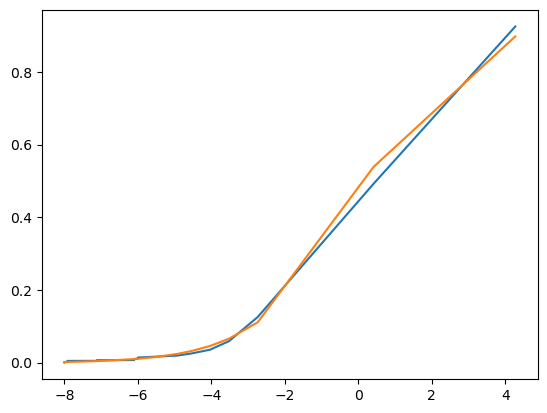

In [245]:
# plt.plot(cal_bins['log_odds'],cal_bins['score'])
plt.plot(cal_bins['log_odds_adj'],cal_bins['score_raw'])
plt.plot(cal_bins['log_odds_adj'],funcg(cal_bins['log_odds_adj'], *popt))

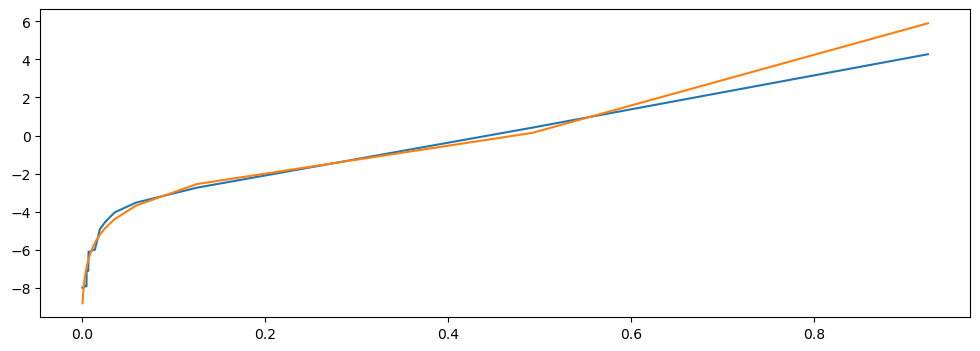

In [246]:
# look at the smooth curve fit to see if it's OK.
plt.figure(figsize=(12,4))
plt.plot(cal_bins['score_raw'], cal_bins['log_odds_adj'])
plt.plot(cal_bins['score_raw'], funcf(cal_bins['score_raw'], *popt))

In [247]:
# The fit looks pretty good
cal_bins['fit'] = funcf(cal_bins['score_raw'], *popt)
cal_bins.head(10)

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,score_raw,prob(%),odds,log_odds,log_odds_adj,fit
1,1.0,975.0,975.0,0.0,100.000000,0.000000,975.0,975.0,0.0,0.000110,0.000000,0.000001,-19.895043,-8.0,-8.810468
2,2.0,975.0,975.0,0.0,100.000000,0.000000,1950.0,1950.0,0.0,0.000168,0.000000,0.000001,-19.895043,-8.0,-8.758633
3,3.0,975.0,975.0,0.0,100.000000,0.000000,2925.0,2925.0,0.0,0.000207,0.000000,0.000001,-19.895043,-8.0,-8.725608
4,4.0,975.0,975.0,0.0,100.000000,0.000000,3900.0,3900.0,0.0,0.000244,0.000000,0.000001,-19.895043,-8.0,-8.694102
5,5.0,975.0,975.0,0.0,100.000000,0.000000,4875.0,4875.0,0.0,0.000283,0.000000,0.000001,-19.895043,-8.0,-8.662282
6,6.0,975.0,975.0,0.0,100.000000,0.000000,5850.0,5850.0,0.0,0.000321,0.000000,0.000001,-19.895043,-8.0,-8.631510
7,7.0,975.0,975.0,0.0,100.000000,0.000000,6825.0,6825.0,0.0,0.000361,0.000000,0.000001,-19.895043,-8.0,-8.600145
8,8.0,975.0,974.0,1.0,99.897436,0.102564,7800.0,7799.0,1.0,0.000406,0.102564,0.001028,-9.926336,-8.0,-8.565759
9,9.0,975.0,975.0,0.0,100.000000,0.000000,8775.0,8774.0,1.0,0.000450,0.000000,0.000001,-19.895043,-8.0,-8.532464
10,10.0,975.0,975.0,0.0,100.000000,0.000000,9750.0,9749.0,1.0,0.000494,0.000000,0.000001,-19.895043,-8.0,-8.500639


In [248]:
# Here's the calibrated score
cal_bins['score_calib'] = base + delta * cal_bins['fit'] - delta * np.log2(odds_at_base)
cal_bins['score_calib'].fillna(999, inplace=True)
cal_bins['score_calib'].clip(upper=999, inplace=True)

In [249]:
pd.set_option('display.max_rows', 100)
cal_bins.to_csv('cal_bins.csv')
cal_bins.tail(30)

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,score_raw,prob(%),odds,log_odds,log_odds_adj,fit,score_calib
71,71.0,975.0,971.0,4.0,99.589744,0.410256,69225.0,69136.0,86.0,0.003797,0.410256,0.004120,-7.922967,-7.921480,-7.115124,524.136081
72,72.0,975.0,971.0,4.0,99.589744,0.410256,70200.0,70107.0,90.0,0.003945,0.410256,0.004120,-7.922967,-7.921480,-7.076560,524.907370
73,73.0,975.0,973.0,2.0,99.794872,0.205128,71175.0,71080.0,92.0,0.004102,0.205128,0.002057,-8.925575,-7.921480,-7.036762,525.703321
74,74.0,975.0,975.0,0.0,100.000000,0.000000,72150.0,72055.0,92.0,0.004271,0.000000,0.000001,-19.895043,-7.921480,-6.995082,526.536925
75,75.0,975.0,974.0,1.0,99.897436,0.102564,73125.0,73029.0,93.0,0.004453,0.102564,0.001028,-9.926336,-7.921480,-6.951474,527.409077
76,76.0,975.0,968.0,7.0,99.282051,0.717949,74100.0,73997.0,100.0,0.004644,0.717949,0.007232,-7.111302,-7.111302,-6.907331,528.291943
77,77.0,975.0,973.0,2.0,99.794872,0.205128,75075.0,74970.0,102.0,0.004842,0.205128,0.002057,-8.925575,-7.111302,-6.862934,529.179889
78,78.0,975.0,973.0,2.0,99.794872,0.205128,76050.0,75943.0,104.0,0.005048,0.205128,0.002057,-8.925575,-7.111302,-6.818049,530.077579
79,79.0,975.0,972.0,3.0,99.692308,0.307692,77025.0,76915.0,107.0,0.005267,0.307692,0.003087,-8.339369,-7.111302,-6.771987,530.998815
80,80.0,975.0,972.0,3.0,99.692308,0.307692,78000.0,77887.0,110.0,0.005514,0.307692,0.003087,-8.339369,-7.111302,-6.721746,532.003643


In [250]:
calib.head()

,score_raw,Fraud
75395,0.000030,0
78666,0.000033,0
35826,0.000034,0
54173,0.000036,0
66936,0.000039,0


In [251]:
calib['score_calib'] = base - delta * np.log2(odds_at_base) + delta * funcg(calib['score_raw'], *popt)
calib['score_calib'].fillna(999, inplace=True)
calib['score_calib'].clip(upper=999, inplace=True)
calib.head()

,score_raw,Fraud,score_calib
75395,0.000030,0,675.799550
78666,0.000033,0,675.799561
35826,0.000034,0,675.799564
54173,0.000036,0,675.799570
66936,0.000039,0,675.799581


In [252]:
calib.tail()

,score_raw,Fraud,score_calib
42450,0.997181,1,679.070886
71287,0.997245,1,679.071080
42570,0.997312,1,679.071280
42693,0.997383,1,679.071495
71282,0.997488,1,679.071810


In [253]:
calib.describe()

,score_raw,Fraud,score_calib
count,97496.000000,97496.000000,97496.000000
mean,0.019516,0.020996,675.864841
std,0.106233,0.143371,0.352126
min,0.000030,0.000000,675.799550
25%,0.001082,0.000000,675.803153
50%,0.001969,0.000000,675.806189
75%,0.004553,0.000000,675.815036
max,0.997488,1.000000,679.071810


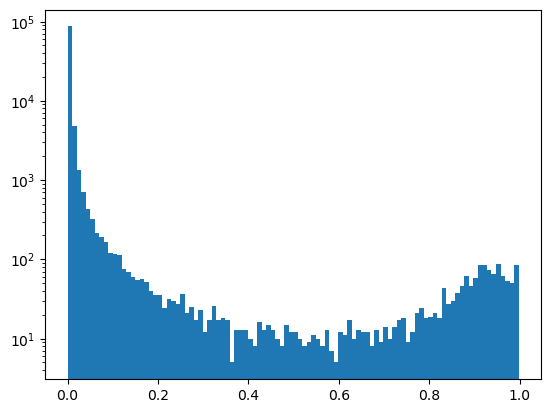

In [254]:
nbins=100
plt.hist(calib['score_raw'],bins=nbins)
plt.yscale('log')

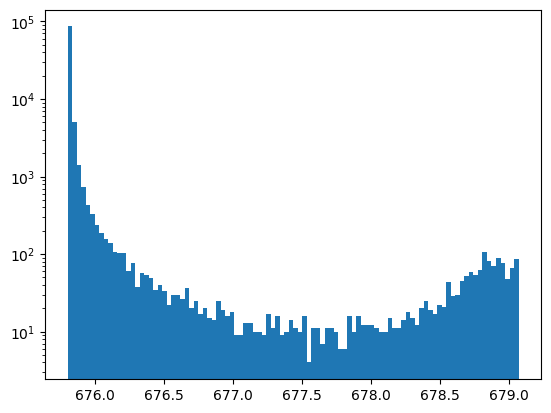

In [255]:
plt.hist(calib['score_calib'],bins=nbins)
plt.yscale('log')

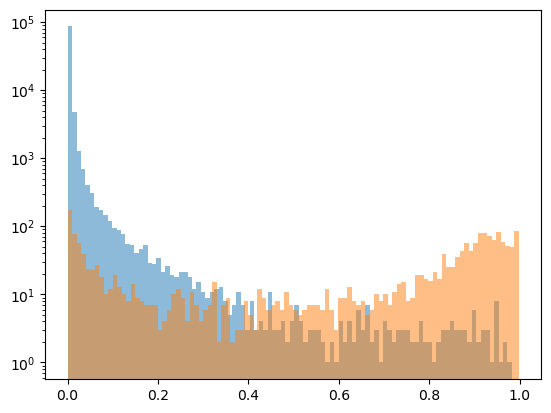

In [256]:
goods = calib[calib['Fraud']==0]
bads = calib[calib['Fraud']==1]
plt.hist(goods['score_raw'],bins = nbins, alpha = .5)
plt.hist(bads['score_raw'],bins = nbins, alpha = .5)
plt.yscale('log')

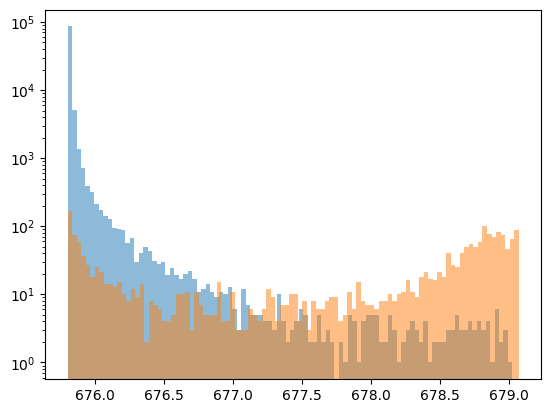

In [257]:
plt.hist(goods['score_calib'],bins = nbins, alpha = .5)
plt.hist(bads['score_calib'],bins = nbins, alpha = .5)
plt.yscale('log')

In [258]:
print("duration: ", datetime.now() - start_time)

duration:  0:21:18.887526
